# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Исходные данные

Данные находятся в файле /datasets/autos.csv

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

# Cхема выполнения исследования

1. Загрузка и подготовка данных.
2. Обучение разных моделей. Для каждой нужно попробовать различные гипепараметеры.
3. Анализ скорости работы и качества моделей.

# Примечания

- Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:

## Подготовка данных

### Знакомство с данными

In [1]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# ячейка импорта

import pandas as pd
import numpy as np

import random                    # для операции с назначением случайного года

import lightgbm as lgb           # импорт LightGBM

import matplotlib.pyplot as plt  # для построения графиков
import seaborn as sns            # для построения графиков
import warnings                  # добавил чтобы убирать предупреждения

from sklearn.preprocessing import StandardScaler     # для масштабирования
from sklearn.model_selection import train_test_split  # для разбиения на выборки
from sklearn.model_selection import GridSearchCV   # для подбора гиперпараметров

# модель регрессия
from sklearn.linear_model import LinearRegression   # модель линейной регрессии
from sklearn.ensemble import RandomForestRegressor  # модель случанйого леса 
from sklearn.tree import DecisionTreeRegressor      # модель решающего дерева
from sklearn.dummy import DummyRegressor            # импорт DummyRegressor
from lightgbm import LGBMRegressor                   # импорт LGBMRegressor

from sklearn.model_selection import cross_val_score  # для кросс-валидации
from sklearn.metrics import make_scorer              # импорт make_scorer
from datetime import datetime                        # для работы с datetime

from sklearn.metrics import mean_squared_error       # для расчета mse (хотя в итоге фунцию для rmse решил сделать)

from sklearn.preprocessing import OrdinalEncoder     # для преобразования признаков в категориальные


pd.options.display.float_format = '{:,.2f}'.format  # форматирование числа разрядов после запятой 

random_state=12345


<div class="alert alert-success">
<b>👍 Успех:</b> Все импорты на месте
</div>

In [4]:
# открытие файла (на случай если буду открывать вне тренажера, прописал альтернативный путь)
try:
    data = pd.read_csv('/datasets/autos.csv', parse_dates = ['DateCrawled', 'DateCreated', 'LastSeen'])
    
except:
    data_path = 'C:/Users/v.kozlovskiy/Desktop/LRN_on_desk/_NOTEBOOKS/my_yp_and_others/datafiles/'  
    data = pd.read_csv(data_path + '11_autos.csv')

In [5]:
# смотрю на данные
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


видно, что ряд признаков количественные:

- целевой - Price, 
- RegistrationYear - год регистрации (хотя его можно воспринимать и как категориальный), 
- Power (мощность), 
- Kilometer (пробег), 
- PostalCode (индекс), хотя не думаю, что индекс является количественной информацией - по факту он категориальный
- NumberOfPictures (его можно как категориальный воспринять, пока везде нули видны)

ряд категориальные:
- VehicleType - тип машины (автобус, минивэн и прочее) - он явно категориальный
- Gearbox - коробка передач - тоже явно категориальный
- Model - модель - категориальный
- FuelType - тип топлива (бензин,гибрид и пр.) - тоже категориальный
- Brand - марка - тоже явно категориальный
- RegistrationMonth - как и год можно воспринимать и как количественный и как категориальный (хотя с учетом того что месяцев вряд ли больше 12 можно считать и категориальным)
- NotRepaired - был ли ремонт - явно категориальный

и три даты:
- DateCrawled	
- DateCreated (тут данные до дня, в отличии от двух других)
- LastSeen

In [6]:
# смотрю методом info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- даты в object или int (их можно будет перевести в datetime и сделать количественными, если нужно)
- большая часть категориальных в object, хотя некоторые явно в int
- пропусков немного, но есть. Больше всего в NotRepaired (надо дальше смотреть что тут делать), думаю, что по тем столбцам где пропусков меньше всего датасет можно сократить (где меньше 10%), VehicleType явно связан с Model (возможно и с FuelType, но не точно)

In [7]:
# смотрю методом describe()
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


после решений о преобразовании типов данных в столбцах надо будет еще смотреть, пока видно что:

- с ценой все сокрее всего ок
- с мощностью максимум сильно выше медианы и среднего
- у пробега максимум равен медиане (видимо пробег 150000 км верхний лимит сервиса, но большинство машин как раз такие)
- месяц и год, регистрации и индекс - не думаю, что метод describe тут дает какую-то ионформацию (хотя 1000 и 10000 год выглядят сомнительно, но медиана, среднее и квартили - реалистичные)
- в числе картинок - везде нули - скорее всего признак бессмысленный и надо будет его удалить

<div class="alert alert-success">
<b>👍 Успех:</b> Согласна
</div>

In [8]:
# смотрю методом describe() для столбцов типа object
data.describe(include=[object])

,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


- даты выглядят как количественные значения, притом у DateCreated, уникальных значений на порядки меньше, что логично, учитывая то что там данные по дням, а в других датах до секунд
- остальные столбцы выглядят как категориальные (причем стоит помнить, что у модели уникальных значений больше, чем у DateCreated)
- коробка передач и была ли машина в ремонте - бинарные признаки, причем у NotRepaired больше всего пропусков - возможно их можно вывести в отдельную категорию unknown, у Gearbox тоже есть пропуски, но меньше (возмжоно тут так же можно сделать, но уверенность меньше)

In [9]:
# посмторю на наличие дубликатов
data.duplicated().sum()

4

дубликатов всего 4 - их можно будет удалить 

In [10]:
# выведу матрицу корреляций
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.00,0.03,0.16,-0.33,0.11,NaN,0.08
RegistrationYear,0.03,1.00,-0.00,-0.05,-0.01,NaN,-0.00
Power,0.16,-0.00,1.00,0.02,0.04,NaN,0.02
Kilometer,-0.33,-0.05,0.02,1.00,0.01,NaN,-0.01
RegistrationMonth,0.11,-0.01,0.04,0.01,1.00,NaN,0.01
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.08,-0.00,0.02,-0.01,0.01,NaN,1.00


после преобразований надо будет посмотреть еще, пока единственное, что видно некоторая отрицательная корреляция цены и пробега (логично)

CPU times: total: 37 s
Wall time: 37 s


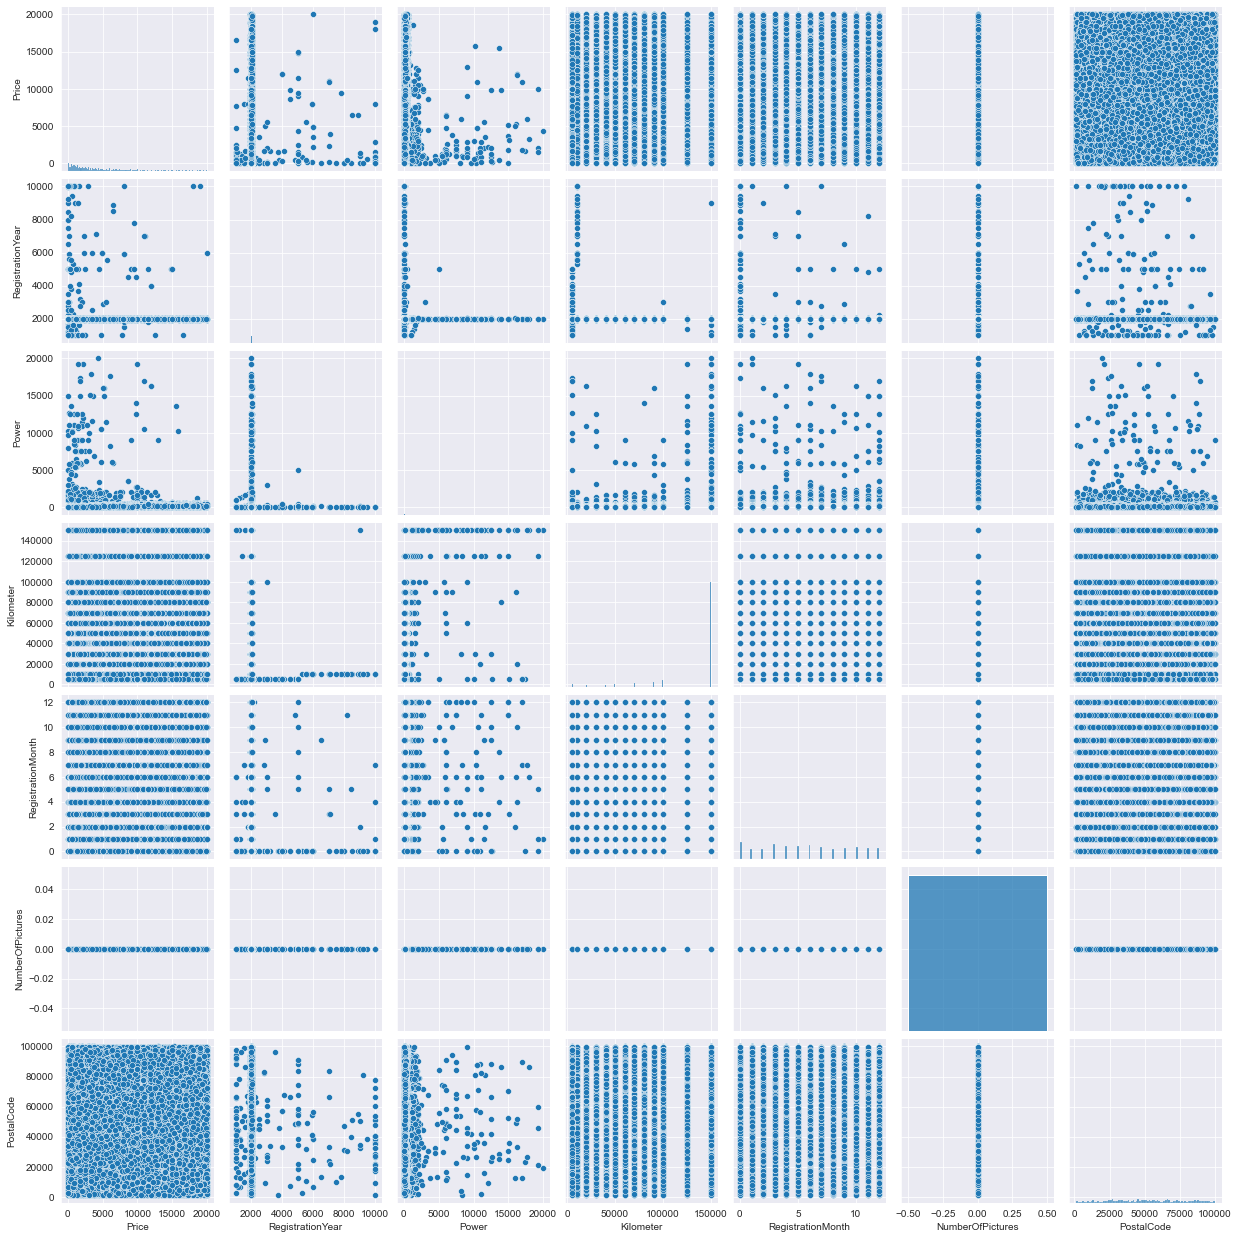

In [11]:
%%time
# выведу pairplot

sns.set_style('darkgrid')
sns.pairplot(data)

пока не очень много всего вижу:
- NumberOfPictures явно не понадобится 
- месяцев явно 13 - (это и из describe видно) - видимо вопрос в точке отсчета (0 или 1) - пока не могу придумать, что с этим делать, т.к. неясно сколько значений из выборки от какой точки отсчета шли. Еще 13ое значение может значить, что месяц неизвестен.
- есть ощущение, что пробег тоже можно воспринимать как категориальный признак - надо будет посмотреть с value_counts (как и другие признаки) 
- 2000 год преобладает - хотя судя по остальным значением, все что не попадает в него (и рядом) это странные выбросы
- Насчет индекса - есть ощущение, что он тоже не принесет пользы - с ценой у него связи точно нет, с остальными признаками
- ситуация с мощностью напоминает ситуацию с годом

In [12]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [13]:
# переведу названия столбцов в змеиный регистр - т.к. так всегда рекомендуется делать
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [14]:
[print(data[i].value_counts()) for i in data.columns]

2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-02 14:50:21    5
2016-03-23 13:50:19    5
                      ..
2016-03-20 16:48:06    1
2016-03-22 21:51:04    1
2016-03-11 16:25:36    1
2016-03-31 12:47:30    1
2016-03-19 18:57:12    1
Name: date_crawled, Length: 271174, dtype: int64
0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: price, Length: 3731, dtype: int64
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: registration_year, Length: 151, dtype: int64
manual    268251
auto       66285
Name: gearbox, dtype: int64
0  

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

пока у меня есть ощущение, что здесь категориальными можно будет считать вообще все признаки
- явно количественным выглядит только целевой и скорее всего мощность (но это не так точно)
- date_crawled и last_seen скорее всего тоже имеет смысл окурглить до дня (как и date_created) - тогда их число скорее всего станет сопоставимым с другими категориями (конечно можно предположить, что время суток этих столбцов имеет значение, но думаю, что это маловероятно)
- насчет месяцев можно думать дальше, но прямого способа понять как их уменьшить до 12 не вижу
- индекс это явно множество категорий и смысла в нем я пока не вижу

пока что хочу обработать выбросы ("выбросы категорий") - попробовать разобраться с признаками и дальше посмотреть на данные еще, финально решить, что делать с признаками

Text(0.5, 1.0, 'Гистограмма индекса')

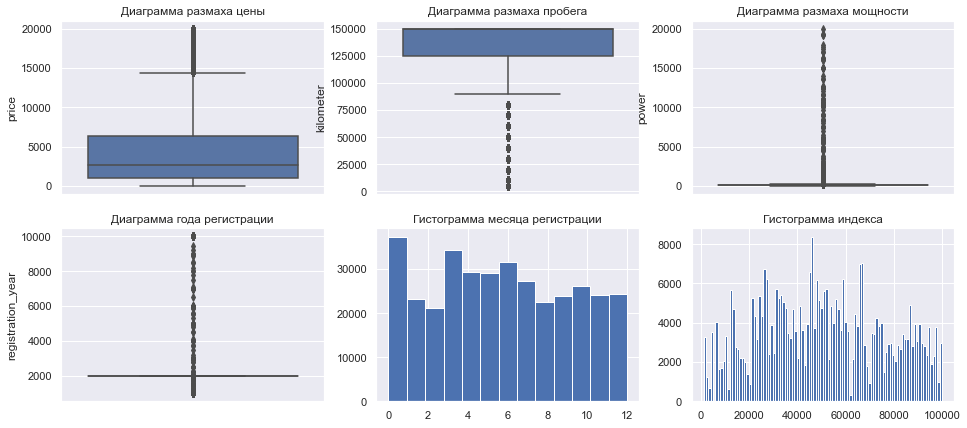

In [15]:
# выведу диаграммы размаха признаков, которые видны в количественном виде
plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'darkgrid', font_scale=1)

plt.subplot(2, 3, 1)
sns.boxplot(y=data['price'])
plt.title('Диаграмма размаха цены')

plt.subplot(2, 3, 2)
sns.boxplot(y=data['kilometer'])
plt.title('Диаграмма размаха пробега')

plt.subplot(2, 3, 3)
sns.boxplot(y=data['power'])
plt.title('Диаграмма размаха мощности')

plt.subplot(2, 3, 4)
sns.boxplot(y=data['registration_year'])
plt.title('Диаграмма года регистрации')

plt.subplot(2, 3, 5)
# просто хочу взглянуть
data['registration_month'].hist(bins=13)
plt.title('Гистограмма месяца регистрации')

plt.subplot(2, 3, 6)
# просто хочу взглянуть
data['postal_code'].hist(bins=100)
plt.title('Гистограмма индекса') 


- Думаю, что целевой признак выглядит реалистичным и выход части значений за границы усов - это нормально
- пробег это явно ряд категориальных значений причем больше всего максимальных - думаю, что здесь не надо ничего делать
- с мощностью явно видны большие выбросы - думаю, что надо ограничить датасет значениями мощности несильно выходяящими за границы усов
- примерно так же с годом регистрации - понятно что много нереалистичных значений - посмотрю на максимальные и минимальные значения столбцов с датами (машины явно не должны быть старше 2016, и вряд ли моложе середины 20 века)
- месяц регистрации на гистограмме выглядит +- реалистично, сейчас уже не думаю, что 13 значение означает неизвестность месяца. Скорее всего 2 точки отсчета (0 и 1), странно, что в 0 месяце (январь) значений больше всего, но пока что планирую ничего не делать с этим столбцом, т.к. неясно что и не думаю, что это сильно повлияет на результат
- насчет индекса продолжаю сомневаться что эти данные несут полезную информацию

Text(0.5, 1.0, 'Гистограмма пробега')

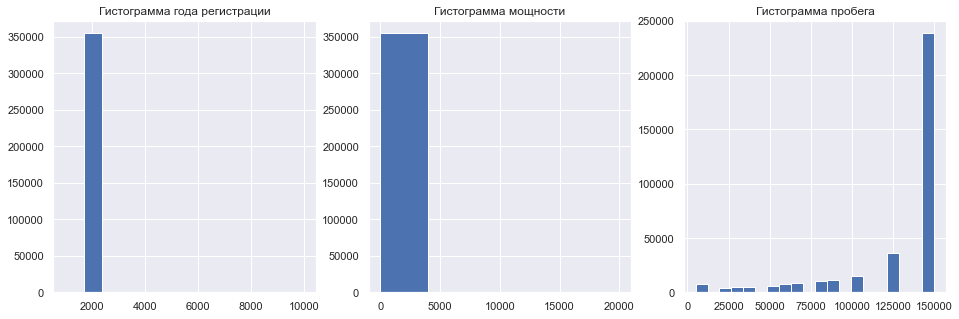

In [16]:
# смотрю на гистограммы года регистрации и мощности (чтобы понять насколько видны на них выбросы) и на пробег тоже посмотрю 

plt.figure(figsize=(16, 5))
sns.set(context = 'notebook', style = 'darkgrid', font_scale=1)

plt.subplot(1, 3, 1)

data['registration_year'].hist(bins=13)
plt.title('Гистограмма года регистрации')

plt.subplot(1, 3, 2)

data['power'].hist(bins=5)
plt.title('Гистограмма мощности') 

plt.subplot(1, 3, 3)

data['kilometer'].hist(bins=20)
plt.title('Гистограмма пробега') 


- явно выбросы в годе регистрации и мощности можно будет удалить
- пробег выглядит как ряд категорий (что было видно)

<div class="alert alert-success">
<b>👍 Успех:</b> Да, скорее всего пробег можно только выбрать из списка, а не ввести вручную
</div>

### Предобработка данных

#### Обработка выбросов в registration_year и power

In [17]:
# сделаю список с названиями столбцов несущих информацию о дате и времени
dt_list = ['date_crawled', 'date_created', 'last_seen']

In [18]:
# посмотрю на минимальные и максимальные значения дат
[print('Минимальное значение:', i, data[i].min(), 'Максимальное значение:', i, data[i].max()) for i in dt_list]

Минимальное значение: date_crawled 2016-03-05 14:06:22 Максимальное значение: date_crawled 2016-04-07 14:36:58
Минимальное значение: date_created 2014-03-10 00:00:00 Максимальное значение: date_created 2016-04-07 00:00:00
Минимальное значение: last_seen 2016-03-05 14:15:08 Максимальное значение: last_seen 2016-04-07 14:58:51


[None, None, None]

In [19]:
df = data.query('registration_year <= 2016 and registration_year > 1950')

<AxesSubplot:>

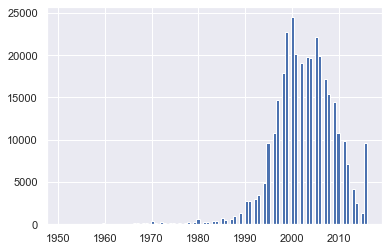

In [20]:
df.reset_index(drop=True)
df['registration_year'].hist(bins=100)

<AxesSubplot:ylabel='registration_year'>

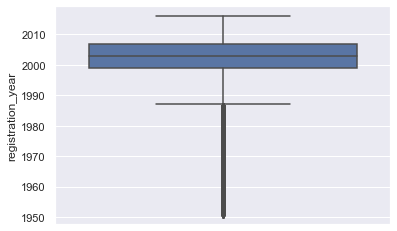

In [21]:
sns.boxplot(y=df['registration_year'])

<AxesSubplot:ylabel='registration_year'>

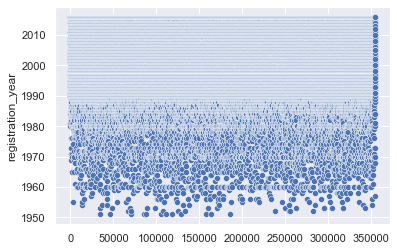

In [22]:
sns.scatterplot(data=df, x=df.index, y='registration_year')

в общем от 1950 года данные выглядят уже реалистичнее, хотя более менее заметно рост машин начинается с 1980х, еще в 1960 на диаграмме рассеяния выделяется линия точек - думаю интервал 1959-2016 можно использовать  

То что не входит в интервал приведу к крайним значениям интервала </div>

In [23]:
# функция для замены года на крайние значения
def registration_year_proc(year):
    if year > 2016:
        return 2016
    if year < 1959:
        return 1959
    else:
        return year


In [24]:
# сначала проверю не меняя основной датасет
df = data
df['registration_year'] = df['registration_year'].apply(registration_year_proc)

<AxesSubplot:>

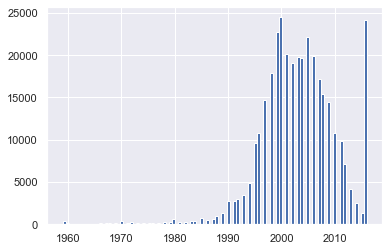

In [25]:
df['registration_year'].hist(bins=100)

кажется, что здесь что-то не так - 2016 год за счет того что имело значения выше стал нереалистично сильно представлен </div>

In [26]:
df.query('registration_year == 2016').describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,"24,129.00","24,129.00","24,129.00","24,129.00","24,129.00","24,129.00","24,129.00"
mean,"2,735.40","2,016.00",85.15,"132,501.55",4.70,0.00,"48,002.45"
std,"3,332.72",0.00,269.76,"37,061.57",4.00,0.00,"25,222.84"
min,0.00,"2,016.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,699.00,"2,016.00",0.00,"125,000.00",0.00,0.00,"27,628.00"
50%,"1,500.00","2,016.00",75.00,"150,000.00",4.00,0.00,"46,117.00"
75%,"3,490.00","2,016.00",115.00,"150,000.00",8.00,0.00,"66,333.00"
max,"20,000.00","2,016.00","16,011.00","150,000.00",12.00,0.00,"99,998.00"


возмжно (как и в случае с power=0), значения registration_year > 2016 это скорее пропуски (меньше 1959+- тоже) </div>

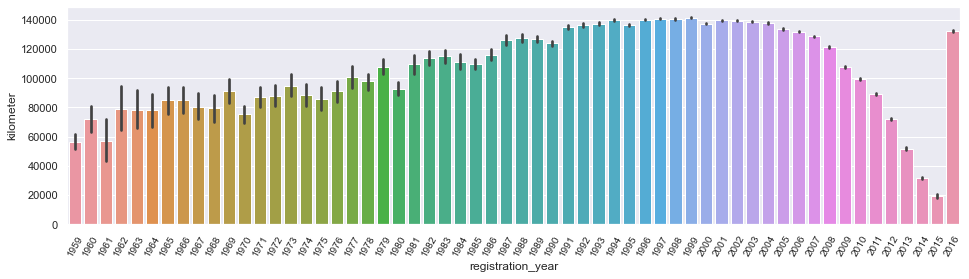

In [27]:
# решил посмотреть на связь пробега с годом регистрации (предполагагю, что она может быть)
plt.figure(figsize=(16, 4))
sns.set(context = 'notebook', style = 'darkgrid', font_scale=1)

sns.barplot(data=df, x='registration_year', y='kilometer')
plt.xticks(fontsize = 10, position = (-0.03, 0), rotation = 60)  # настройка подписей
plt.show()


вида странная тенденция: у старых машин чаще более малый пробег (но больше разброс) и вообще старых машин меньше, начиная с 90х пробег держится на максимальной отметке и где-то с середины 2000х начинает заметно падать и в 2015 достигает минимума, а в 2016 резко вырастает до максимума 
(возможно неверно делаю что вывожу этот график на примере когда все что выше 2016 приведено к 2016 - вообще я посмотрел и до приведения (не стал выводить, чтобы не заполнять все схожими графиками), но и до привдения в 2016 был максимальный пробег) - отсюда думаю, что данные выше 2016 (включая часть 2016) аномальны по году регистрации.   
    
пока у меня появился такой вариант действий - все года регистрации после 2015 считать пропусками и заполнять ориентируясь на пробег, но зависимость видна примерно с середины 2000х, думаю, что большая часть значений после 2015 будет с пробегом 150000 


In [28]:
# посмотрю сколько машин относится к периоду 1990-2016
df = data.query('registration_year > 1990 and registration_year < 2016')
df.shape

(317765, 16)

In [29]:
# посмотрю с помощью value_counts значения пробег у машин старше 2015
df = data.query('registration_year > 2015')
print(df.shape)
print(df['kilometer'].value_counts())

(24129, 16)
150000    17994
125000     2141
5000        801
100000      749
90000       563
80000       437
70000       336
60000       253
20000       227
50000       217
30000       172
40000       141
10000        98
Name: kilometer, dtype: int64




думаю что, для аномальных значений 2016 можно соотнести период 2004 - 2015 с определенными значениями пробега, а для значений пробега 140000, выбирать случайный год из интервала 1991-2003. (те у кого пробег 5000 могут быть и 2016)
пока что приведу значения меньше 1959 к 1959, а с тем что выше 2015 буду работать на этапе обработки пропусков


In [30]:
# функция для замены года на крайние значения (обновленная)
def registration_year_proc_lower(year):
    if year < 1959:
        return 1959
    else:
        return year


In [31]:
data['registration_year'] = data['registration_year'].apply(registration_year_proc_lower)

**Обработка power**

<AxesSubplot:ylabel='power'>

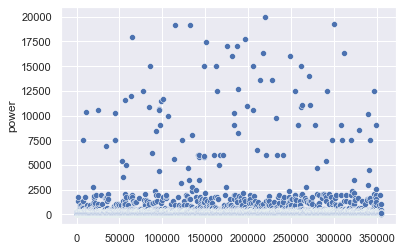

In [32]:
# посмотрю на рассеяние мощности
sns.scatterplot(data=data, x=data.index, y='power')

сильных выбросов мало - их точно можно убирать, верхнюю границу того что можно оставить буду ориентировать на 2IQR (чтобы выйти за границы "уса", но не сильно), на нижнюю посмотрю потом

In [33]:
upper = data['power'].quantile(0.75) + 2*(data['power'].quantile(0.75) - data['power'].quantile(0.25)) 
upper

291.0

In [34]:
df = data.query('power <= 291')

<AxesSubplot:ylabel='power'>

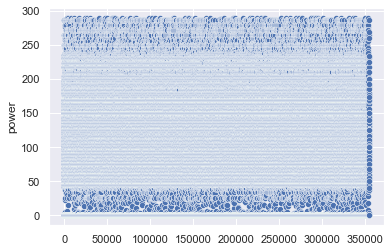

In [35]:
sns.scatterplot(data=df, x=df.index, y='power')

<AxesSubplot:>

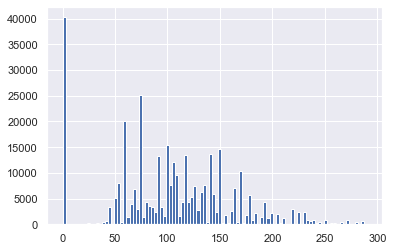

In [36]:
df['power'].hist(bins=100)

35000 нулевых мощностей - это заметно - не совсем понимаю, что имеется в виду - ошибка в записи (или может быть машины без двигателя продают) - сделаю срез по power=0 и посмотрю немного на него.

In [37]:
df = df.query('power == 0')
df.shape

(40225, 16)

In [38]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,"40,225.00","40,225.00","40,225.00","40,225.00","40,225.00","40,225.00","40,225.00"
mean,"2,171.86","2,001.82",0.00,"126,035.92",4.00,0.00,"46,500.85"
std,"3,045.86",9.80,0.00,"45,350.96",4.11,0.00,"25,330.41"
min,0.00,"1,959.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,400.00,"1,998.00",0.00,"125,000.00",0.00,0.00,"26,607.00"
50%,"1,050.00","2,001.00",0.00,"150,000.00",3.00,0.00,"45,473.00"
75%,"2,600.00","2,007.00",0.00,"150,000.00",7.00,0.00,"65,428.00"
max,"20,000.00","2,016.00",0.00,"150,000.00",12.00,0.00,"99,998.00"


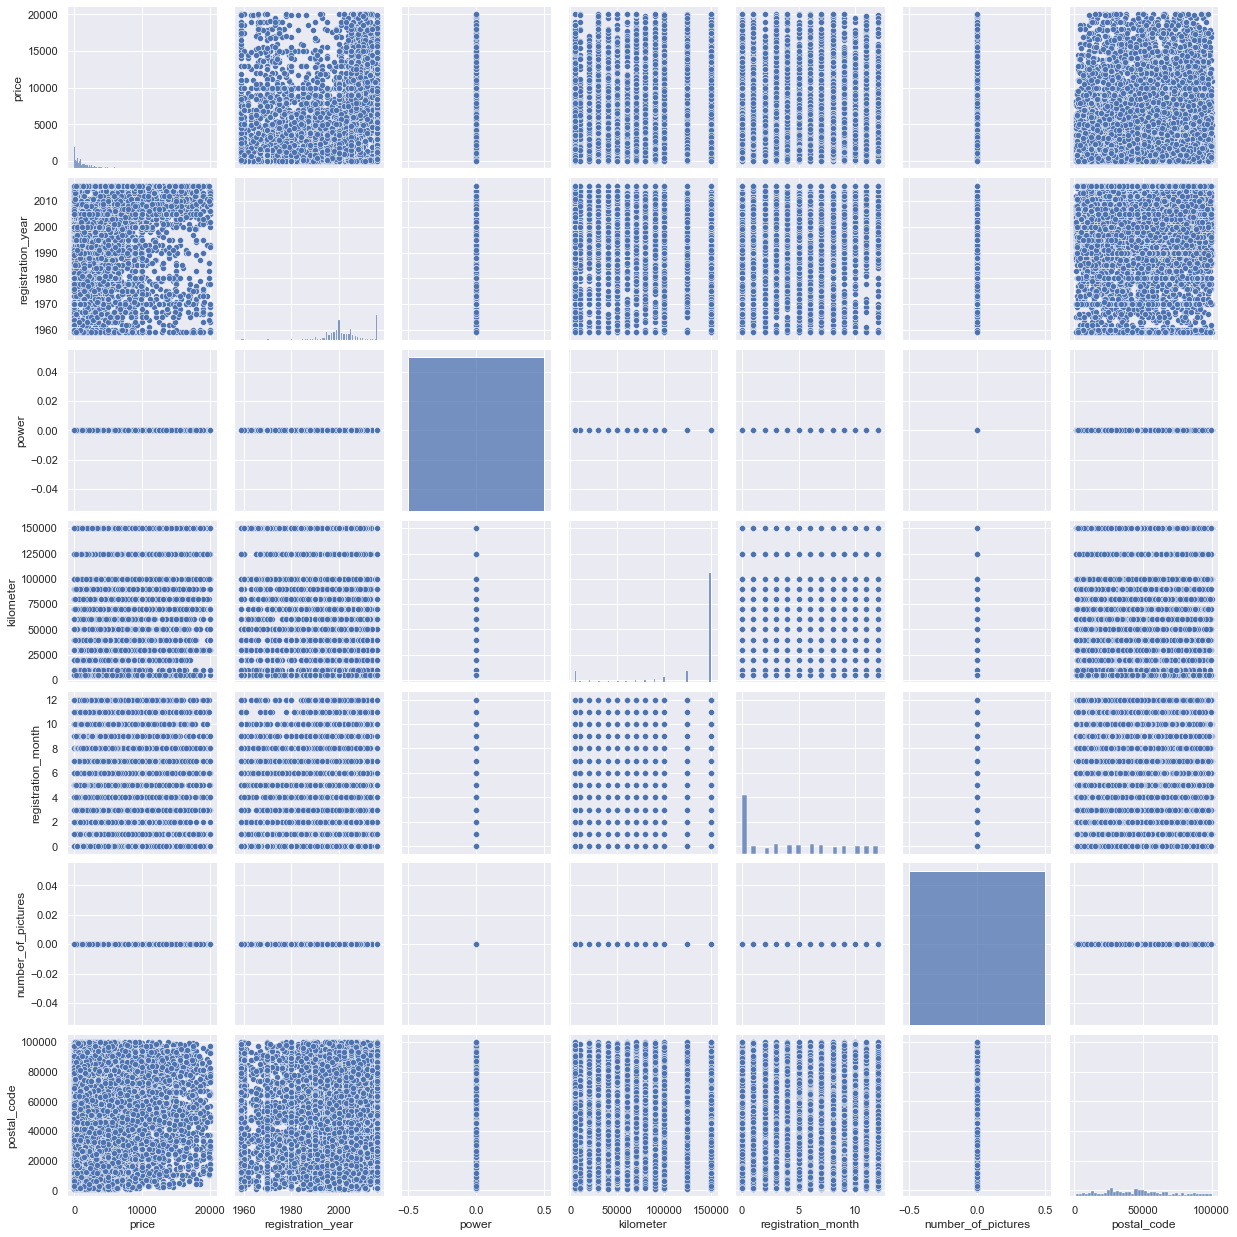

In [39]:
sns.pairplot(df)

мне кажется, что данные выглядт вполне реалистичными - поэтому хочу заменить ноль на медиану с опорой на данны о типе кузова (заметно, что в нулевом месяце значений с нулевой мощностью больше)

есть ощущение, что данные шли из разных источников и в одном из источников мощности равнялись нулю, а месяц преимущественно был нулевым. Возможно что нули здесь это заделанные пропуски (в power нет пропусков)

**посмотрю еще раз на столбец с индексом, чтобы понять несет ли он смысловую нагрузку**

Text(0.5, 1.0, 'Диаграмма рассеяния индекса и типа топлива')

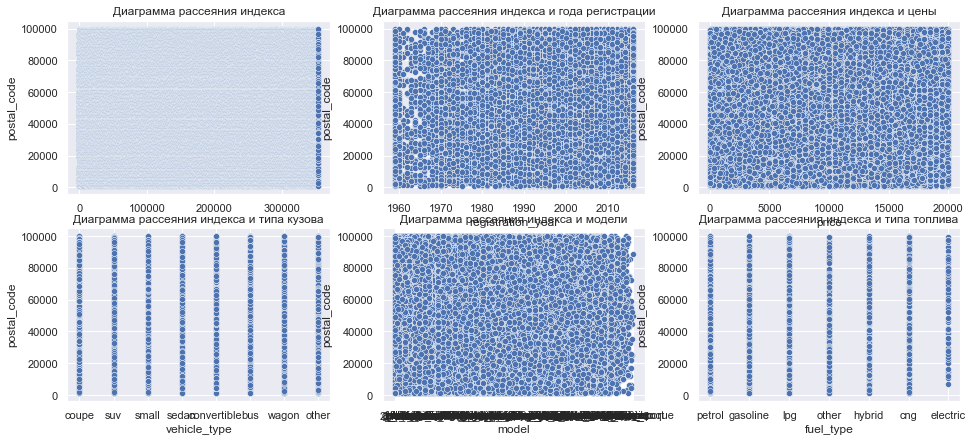

In [40]:
# выведу диаграммы рассеяния индекса и важных признаков

plt.figure(figsize=(16, 7))
sns.set(context = 'notebook', style = 'darkgrid', font_scale=1)

plt.subplot(2, 3, 1)
sns.scatterplot(data=data, x=data.index, y='postal_code')
plt.title('Диаграмма рассеяния индекса')

plt.subplot(2, 3, 2)
sns.scatterplot(data=data, x='registration_year', y='postal_code')
plt.title('Диаграмма рассеяния индекса и года регистрации')

plt.subplot(2, 3, 3)
sns.scatterplot(data=data, x='price', y='postal_code')
plt.title('Диаграмма рассеяния индекса и цены')

plt.subplot(2, 3, 4)
sns.scatterplot(data=data, x='vehicle_type', y='postal_code')
plt.title('Диаграмма рассеяния индекса и типа кузова')

plt.subplot(2, 3, 5)
sns.scatterplot(data=data, x='model', y='postal_code')
plt.title('Диаграмма рассеяния индекса и модели')

plt.subplot(2, 3, 6)
sns.scatterplot(data=data, x='fuel_type', y='postal_code')
plt.title('Диаграмма рассеяния индекса и типа топлива')


<AxesSubplot:>

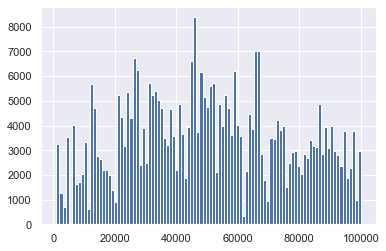

In [41]:
# взгляну на разброс значений
data['postal_code'].hist(bins=100)

In [42]:
# посмотрю на то как выглядя чаще представленные индексы
data.groupby('postal_code')['postal_code'].agg('count').sort_values(ascending=False).head(20)

postal_code
10115    819
65428    613
66333    343
32257    317
44145    317
52525    306
26789    296
78224    293
38518    291
13357    290
48599    289
48249    279
60311    276
51065    274
53757    273
52249    268
40764    267
50354    264
60386    262
26871    261
Name: postal_code, dtype: int64

In [43]:
# посмотрю на минимальные и максимальные значения
print(data['postal_code'].min())

print(data['postal_code'].max())

1067
99998



видно что несколько индексов встречаются чаще, но в любом случае категорий очень много - возможно индекс можно оставить и в первоначальном виде, но хочу попробовать разделить индекс на несколько категорий (исходя из того что локации со сходными индексами скорее всего находятся рядом


In [44]:
# столбец для выделения зон
data['area'] = data['postal_code']

In [45]:
# функция для выделения географических категорий
def area(area):
    if area >= 90000:
        return 0
    if area >= 80000:
        return 1
    if area >= 70000:
        return 2
    if area >= 60000:
        return 3
    if area >= 50000:
        return 4
    if area >= 40000:
        return 5
    if area >= 30000:
        return 6
    if area >= 20000:
        return 7
    if area >= 10000:
        return 8
    else:
        return 9

In [46]:
data['area'] = data['postal_code'].apply(area)

<AxesSubplot:>

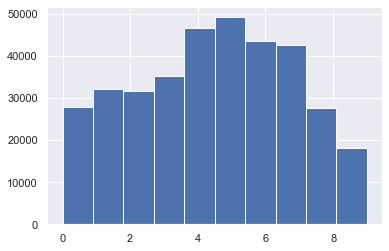

In [47]:
# смотрю на гистограмме    
data['area'].hist(bins=10)

<AxesSubplot:xlabel='area', ylabel='price'>

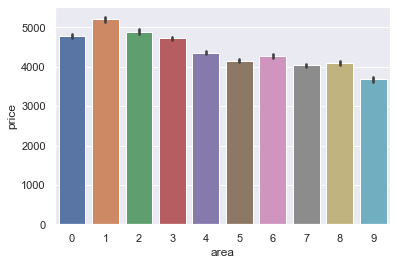

In [48]:
# и столбчатой диаграмме (в зависимости от цены)
sns.barplot(data=data, x='area', y='price')

в общем мне кажется, что некоторая информативность (хотя и небольшая) здесь есть и это может быть лучше для модели, чем полное отсутствие данных (хотя возможно еще лучше вообще неизмененный столбец дать - но планирую его удалить) - пока оставлю и area и postal_code (на этапе разделения на выборки один из них удалю)


In [49]:
# удаление 'number_of_pictures'
data = data.drop(['number_of_pictures'], axis=1)

посмотрю отдельно на целевой признак - цену

<AxesSubplot:>

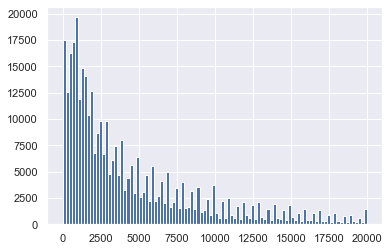

In [50]:
# посмотрю на распределение целевого признака
data['price'].hist(bins=100)

распределение цены похоже на распределение Пуассона, много нулевых значений и значений малой цены 

In [51]:
print('Цена равна 0:', data.query('price == 0')['price'].count())
print('Цена меньше 200:', data.query('price <= 200')['price'].count())

Цена равна 0: 10772
Цена меньше 200: 19448


Почти 10 тыс. машин продаются за 0 и еще почти 10 дешевле 200 (вероятно имеются в виду доллары) в принципе машина за 200 долларов продаваться может, но насчет 100 сильно сомневаюсь. Что значит 0 тоже не вполне ясно: возможно кто-то отдает машины (за самовывоз, продает родственникам за доллар, или еще почему-то, возможно это были пропуски, возможно ошибки)
Думаю нужно посмотреть на срез данных по цене меньше, например, 300 долларов

In [52]:
df = data.query('price < 300')
df.shape

(23163, 16)

In [53]:
df.describe()

,price,registration_year,power,kilometer,registration_month,postal_code,area
count,"23,163.00","23,163.00","23,163.00","23,163.00","23,163.00","23,163.00","23,163.00"
mean,86.75,"1,999.60",68.17,"126,041.75",3.74,"46,413.64",4.90
std,102.39,8.92,209.75,"47,264.07",3.98,"26,590.44",2.65
min,0.00,"1,959.00",0.00,"5,000.00",0.00,"1,069.00",0.00
25%,0.00,"1,995.00",0.00,"125,000.00",0.00,"26,180.00",3.00
50%,1.00,"1,999.00",60.00,"150,000.00",3.00,"45,130.00",5.00
75%,199.00,"2,002.00",101.00,"150,000.00",7.00,"66,125.00",7.00
max,299.00,"2,016.00","15,016.00","150,000.00",12.00,"99,998.00",9.00


In [54]:
#sns.pairplot(df)

не вижу точного ответа на вопрос с низкой ценой, явно выдаются нулевые значения и (как и в случае с мощностью нулевой месяц - возможно нулевой месяц это все таки не другая точка отсчета, а пропуск заполненный нулем, как, вероятно, было и в случае мощности и, возможно, в случае цены). 
- думаю, что машины вполне могут продавать за доллар, и за 0 долларов - и хотя мне кажется, что нулевых значений может быть многовато - пока что хоту оставить целевой признак без изменений.

#### Обработка пропусков
по выбросам и лишним столбцам решения появились - теперь надо решить, что делать с пропусками   

(также пропусками считаю нулевые значения в power)   
(нулевые значения в цене и месяце оставлю как есть - там у меня нет такой уверенности, как и на что их менять и надо ли)

In [55]:
# еще раз вызвоу info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  postal_code         354369 non-null  int64 
 14  last_seen           354369 non-null  object
 15  area                354369 non-null  int64 
dtypes:

не думаю, что даты помогут в заполнении. Хотелось бы отталкиваться от представленных полностью столбцов (кроме power).
В случае gearbox и not_repaired хочу ввести категорию unknown  
для остальных сделать цепочку ориентирования на другие столбцы  

думаю, что модель можно выводить из марки (она без пропусков)
тип топлива и тип кузова из модели
мощность из типа кузова

**пропуски в марке автомобиля**

In [56]:
# посмотрю какие модели чаще всего встречаются для каких марок 
df = data.groupby('brand')['model'].agg(pd.Series.mode) # увидел такой подход, чтобы отобразить моду
df = df.reset_index(level=['brand'])
df

,brand,model
0,alfa_romeo,156
1,audi,a4
2,bmw,3er
3,chevrolet,other
4,chrysler,other
5,citroen,other
6,dacia,logan
7,daewoo,matiz
8,daihatsu,cuore
9,fiat,punto


sonstige_autos назову как sonstige_autos, там где встречается other постараюсь объединить other + brand (думаю что это имеет смысл)


как теперь стало понятно sonstige_autos - это другие машины, но это подход не меняет потому что просто марки other исходно не было


In [57]:
data = data.reset_index(drop=True)

In [58]:
data['model'].isna().sum()

19705

In [59]:
# заполняю пропуски нулями
data['model'] = data['model'].fillna(0)

In [60]:
data['model'].isna().sum()

0

In [61]:
# функция для заполнения пропусков (по логике аналогична циклу из предыдущей версии)

def model_correction(row):
    model = row['model']
    brand = row['brand']
    if model == 0:
        for i in range(len(df['brand'])):
            if brand == df['brand'][i]:
                if brand == 'sonstige_autos':
                    return 'sonstige_autos'
                   
                else:
                    return df['model'][i]
                
    else:
        if model == 'other':
            return 'other' + '' + brand
        else:
            return model

In [62]:
%%time
# применение функции
data['model'] = data.apply(model_correction, axis=1)

CPU times: total: 5.53 s
Wall time: 5.52 s


In [63]:
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  postal_code         354369 non-null  int64 
 14  last_seen           354369 non-null  object
 15  area                354369 non-null  int64 
dtypes:

пропуски в model удалены, модель other разнесена между марками 

**заполнение пропусков в типе топлива**

In [64]:
# смотрю на значения fuel_type
data['fuel_type'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

насколько я понимаю petrol и gasoline - синонимы (бензин в разных странах), остальные категории разные 
(возможно есть сходство у lpg и cpg - но они все-таки разные, а для задачи чем больше разного тем лучше, хотя бензин не разный и его лучше объединить) 

In [65]:
# функция для объединения имен бензина
def fuel(fuel_type):
    if fuel_type == 'petrol':
        return 'gasoline' 
    else:
        return fuel_type

In [66]:
# применение функции
data['fuel_type'] = data['fuel_type'].apply(fuel)

In [67]:
# проверка
data['fuel_type'].value_counts()

gasoline    315072
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

In [68]:
# дальше буду действовать аналогично model
df = data.groupby('model')['fuel_type'].agg(pd.Series.mode) # увидел такой подход, чтобы отобразить моду
df = df.reset_index(level=['model'])
df['fuel_type'].unique()

array(['gasoline'], dtype=object)

исходя из того что самым часты для всех моделей является бензин сделаю замену пропусков через fillna

In [69]:
data['fuel_type'] = data['fuel_type'].fillna('gasoline')

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  postal_code         354369 non-null  int64 
 14  last_seen           354369 non-null  object
 15  area                354369 non-null  int64 
dtypes:

**заполнение пропусков в типе кузова**

In [71]:
# смотрю на значения fuel_type
data['vehicle_type'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

здесь не буду ничего объединять - тоже буду ориентироваться на модель

In [72]:
# действую аналогично model
df = data.groupby('model')['vehicle_type'].agg(lambda x: np.random.choice(x.mode(dropna=False)))
df = df.reset_index(level=['model'])
pd.DataFrame(df)
df.head(50)

C:\Users\v.kozlovskiy\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")
C:\Users\v.kozlovskiy\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")
C:\Users\v.kozlovskiy\AppData\Roaming\Python\Python39\site-packages\pandas\core\algorithms.py:968: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,model,vehicle_type
0,100,sedan
1,145,small
2,147,sedan
3,156,sedan
4,159,wagon
5,1_reihe,small
6,1er,sedan
7,200,sedan
8,2_reihe,small
9,300c,wagon


In [73]:
df['vehicle_type'].value_counts()

sedan          69
small          61
suv            46
bus            42
wagon          35
coupe          17
convertible    12
other           2
Name: vehicle_type, dtype: int64

In [74]:
data['vehicle_type'] = data['vehicle_type'].fillna(0)
df['vehicle_type'] = df['vehicle_type'].fillna(0)

In [75]:
data = data.reset_index(drop=True)

In [76]:
# функция для заполнения пропусков в кузове (по логике аналогична циклу из предыдущей версии)

def v_type_correction(row):
    model = row['model']
    vehicle = row['vehicle_type']
    if vehicle == 0:
 
        for i in range(len(df['model'])):
            
            if model == df['model'][i]:
                
                if df['vehicle_type'][i] == 0:
                    return 'other'
                else:
                    return df['vehicle_type'][i]
    else:
        return vehicle

In [77]:
%%time
data['vehicle_type'] = data.apply(v_type_correction, axis=1)

CPU times: total: 22.4 s
Wall time: 22.4 s


In [78]:
# проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  postal_code         354369 non-null  int64 
 14  last_seen           354369 non-null  object
 15  area                354369 non-null  int64 
dtypes:

In [79]:
data['vehicle_type'].value_counts()

sedan          107124
small           90703
wagon           69427
bus             32532
convertible     20475
coupe           16789
suv             12705
other            4614
Name: vehicle_type, dtype: int64

**замена нулей в power**

In [80]:
data['power'].value_counts()

0       40225
75      24023
60      15897
150     14590
101     13298
        ...  
610         1
6006        1
5815        1
6018        1
1241        1
Name: power, Length: 712, dtype: int64

In [81]:
# действую аналогично model
df = data.groupby('model')['power'].agg('median') # здесь решил взять медиану, т.к. данные в цифрах (сначала думал взять моду
# но возникали те же сложности, что на предыдущем этапе, число уникальных значений при этом примерно то же что и было)
df = df.reset_index(level=['model'])
df.columns = ['model', 'power']
pd.DataFrame(df)
df

,model,power
0,100,133.00
1,145,103.00
2,147,120.00
3,156,144.00
4,159,165.00
...,...,...
285,yaris,75.00
286,yeti,110.00
287,ypsilon,60.00
288,z_reihe,170.00


In [82]:
# функция для заполнения нулей в power (по логике аналогична циклу из предыдущей версии)
def power_correction(row):
    model = row['model']
    power = row['power']
    if power == 0:
 
        for i in range(len(df['model'])):
            
            if model == df['model'][i]:    
                return df['power'][i]
            
    if power > 291:
        for i in range(len(df['model'])):
            
            if model == df['model'][i]:    
                return df['power'][i]
        
    else:
        return power

In [83]:
%%time
data['power'] = data.apply(power_correction, axis=1)

CPU times: total: 26.4 s
Wall time: 26.4 s


In [84]:
data['power'].value_counts()

75.00     26002
60.00     21909
90.00     17972
101.00    15609
150.00    14829
          ...  
267.00        2
97.50         1
282.00        1
68.50         1
83.50         1
Name: power, Length: 303, dtype: int64

И теперь обработаю года со значениями больше, чем 2015, как планировал (не знаю насколько верным будет подход, но попробую - наверное альтернатива это просто удалить, то что старше 2015). Может, то что делаю вообще похоже на подгонку данных (но кажется случайный выбор года должен это нивелировать) 


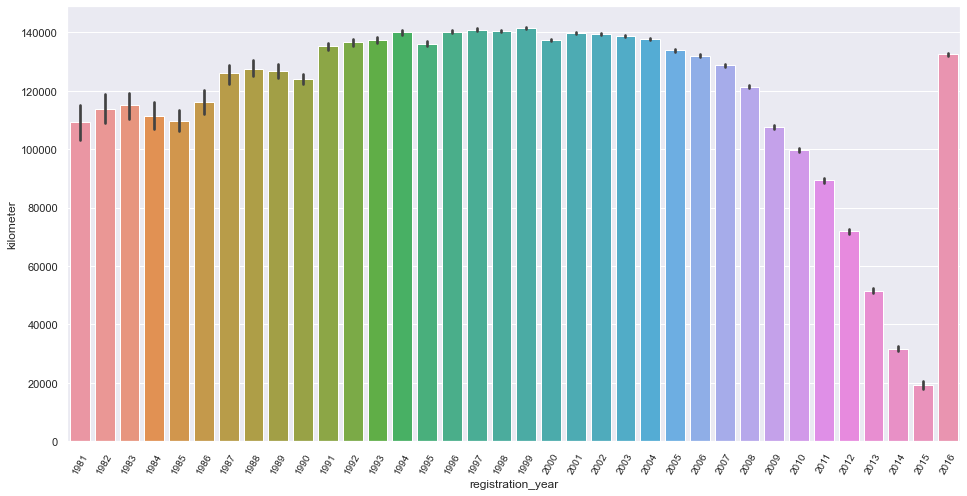

In [85]:
# еще раз выведу барплот (сузив диапазон)

df = data.query('registration_year <= 2016 and registration_year > 1980')

plt.figure(figsize=(16, 8))
sns.set(context = 'notebook', style = 'darkgrid', font_scale=1)

sns.barplot(data=df, x='registration_year', y='kilometer')
plt.xticks(fontsize = 10, position = (-0.03, 0), rotation = 60)  # настройка подписей
plt.show()

In [86]:
data['kilometer'].value_counts().sort_values()

10000       1222
20000       3975
30000       4436
40000       4911
50000       6232
5000        6397
60000       7444
70000       8593
80000      10047
90000      11567
100000     14882
125000     36454
150000    238209
Name: kilometer, dtype: int64

In [87]:
def registration_year_proc_higher(row):
    year = row['registration_year']
    kilometer = row['kilometer']
    if year > 2015:
        if kilometer > 125000:
            random_year = random.randint(1991, 2006)
            return random_year
        if kilometer > 120000:
            return 2008
        if kilometer > 100000:
            return 2009
        if kilometer > 90000:
            return 2010
        if kilometer > 80000:
            return 2011
        if kilometer > 60000:
            return 2012
        if kilometer > 40000:
            return 2013
        if kilometer > 20000:
            return 2014
        if kilometer > 10000:
            return 2015
        else:
            return 2016
    else:
        return year

In [88]:
%%time
data['registration_year'] = data.apply(registration_year_proc_higher, axis=1)

CPU times: total: 3.48 s
Wall time: 3.48 s


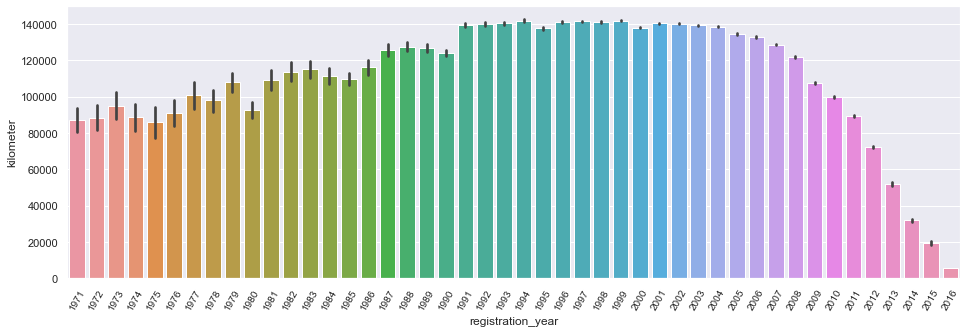

In [89]:
# еще раз выведу барплот (посмотрю что получилось)

df = data.query('registration_year > 1970')

plt.figure(figsize=(16, 5))
sns.set(context = 'notebook', style = 'darkgrid', font_scale=1)

sns.barplot(data=df, x='registration_year', y='kilometer')
plt.xticks(fontsize = 10, position = (-0.03, 0), rotation = 60)  # настройка подписей
plt.show()


выглядит реалтстичнее 

дальше заменю пропуски в gearbox и not_repaired с fillna

In [90]:
data['gearbox'] = data['gearbox'].fillna('unknown')
data['not_repaired'] = data['not_repaired'].fillna('unknown')

еще раз посмотрю info()

In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   date_crawled        354369 non-null  object 
 1   price               354369 non-null  int64  
 2   vehicle_type        354369 non-null  object 
 3   registration_year   354369 non-null  int64  
 4   gearbox             354369 non-null  object 
 5   power               354369 non-null  float64
 6   model               354369 non-null  object 
 7   kilometer           354369 non-null  int64  
 8   registration_month  354369 non-null  int64  
 9   fuel_type           354369 non-null  object 
 10  brand               354369 non-null  object 
 11  not_repaired        354369 non-null  object 
 12  date_created        354369 non-null  object 
 13  postal_code         354369 non-null  int64  
 14  last_seen           354369 non-null  object 
 15  area                354369 non-nul

**дальше хочу округлить до дня datetime чтобы все признаки можно было воспринимать как категориальные**

In [92]:
for i in dt_list:
    data[i] = pd.to_datetime(data[i], format='%Y-%m-%dT%H:%M:%S')
    data[i] = data[i].dt.ceil('1D')

In [93]:
# делаю возраст из даты регистрации
data['car_age'] = 2016 - data['registration_year']

In [94]:
data['car_age'].value_counts()

16    25622
17    23819
11    23248
15    21282
10    21050
13    20832
12    20699
14    20251
18    19060
8     17532
9     17183
19    15822
7     14503
20    11966
6     11513
21    10731
5     10472
4      7951
22     5966
3      4601
23     4587
24     4033
25     3893
2      2850
26     2806
1      1529
27     1318
28      942
0       899
31      756
29      667
36      588
30      538
33      430
57      422
32      399
46      333
34      316
38      285
37      283
35      263
44      213
56      188
40      175
39      173
43      173
42      169
45      167
41      143
47      118
50      113
48      108
49       99
51       82
52       64
53       57
54       46
55       41
Name: car_age, dtype: int64

In [95]:
# удаление 'registration_year'
data = data.drop(['registration_year'], axis=1)

In [96]:
# и еще раз посмотрю на дубликаты  
data.duplicated().sum()

6908

число дубликатов выросло до **7500** (в прошлый раз 8060 притом что тогда было удалено много выбросов) - думаю это произошло после округления времени в date_crawled и last_seen

это:
- DateCrawled — дата скачивания анкеты из базы
- LastSeen — дата последней активности пользователя

т.е. объявления по сути одинаковы, но некоторых схожих, но разных могло быть больше - вообще **7500** (8000) отонсительно **354000** (335000) 
не такое уже большое число дубликатов.   

У меня есть некоторе сомнение, что их уникальный характер (до окургления до дней) может иметь некоторый смысл для модели, но все таки **7500** (8000) значений скорее всего не изменят картину - поэтому хочу их удалить - возможно это ошибочно - тогда после ревью переменю подход

In [97]:
data = data.drop_duplicates()
data = data.reset_index(drop=True)
data.shape

(347461, 16)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347461 entries, 0 to 347460
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        347461 non-null  datetime64[ns]
 1   price               347461 non-null  int64         
 2   vehicle_type        347461 non-null  object        
 3   gearbox             347461 non-null  object        
 4   power               347461 non-null  float64       
 5   model               347461 non-null  object        
 6   kilometer           347461 non-null  int64         
 7   registration_month  347461 non-null  int64         
 8   fuel_type           347461 non-null  object        
 9   brand               347461 non-null  object        
 10  not_repaired        347461 non-null  object        
 11  date_created        347461 non-null  datetime64[ns]
 12  postal_code         347461 non-null  int64         
 13  last_seen           347461 no

### Вывод по шагу-

- удалены дубликаты (в основном появивщиеся после округления дат до дня)
- все признаки можно воспринимать как категориальные


- выбросы не удалял - везде пытался обработать (подходы для года > 2015 может быть не очень хорошо вышли, а может и нормально)
- сделал столбец area на основе индекса (несет меньше информации - но похоже, что несет)
- сделал столбец car_age на основе registration_year (по смыслу примерно то же)
- полностью удалены только фотографии (которых нет), и два столбца на сонове которых сделаны другие


## Обучение моделей

### Подготовка

In [99]:
# выделение признаков и целевого признака
features = data.drop('price', axis=1)
target = data['price']

Далее планирую преобрзовать категориальные признаки для работы с моделью - часто упоминался one hot encoding - но я не вполне понимаю, как его здесь применить - т.е. будет очень много признаков (возможно это и допустимо).
Но пока что хочу применить ordinal encoder (может после ревью станет яснее приемлем ли такой подход)



Решил пойти таким путем:
- сделать преобразование с OHE (решил попробовать использовать все признаки, которые остались на данный момент - area уберу но индекс оставлю
- через Ordinal тоже сделать (для сравнения) - но применять его буду только к LightGBM (для сравнения) - полностью для всех моделей пока не буду делать (т.к. не знаю правилен ли мой подход в целом и чтобы сэкономить время выполнения) - если потребуется сделаю потом ко всему кроме регрессии   
- пока не буду трогать RandomForest (т.к. он долго выполняется, а с OHE еще дольше будет) - я предполагаю, что гиперпараметры будут сходны с предыдущей версией, но наверное все таки везде надо подобрать по новой (если потребуется сделаю в следующей версии)
- (вообще уже пробовал разные действия дальше они будут просто структурнее - увидел, что метрики примерно сходны (хотя и хуже, чем в прошлый раз, но это скорее свяазно с предобработкой) и то, что с OHE работа идет примерно в три раза дольше)


In [100]:
# вариант с удалением area
features = features.drop(['area'], axis=1)

In [101]:
# применение OHE (решил попробовать для всего датасета)
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe.shape

(347461, 352)

In [102]:
features_ohe

,date_crawled,power,kilometer,registration_month,date_created,postal_code,last_seen,car_age,vehicle_type_convertible,vehicle_type_coupe,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
0,2016-03-25,90.00,150000,0,2016-03-24,70435,2016-04-08,23,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2016-03-25,190.00,125000,5,2016-03-24,66954,2016-04-08,5,0,1,...,0,0,0,0,0,0,0,0,0,1
2,2016-03-15,163.00,125000,8,2016-03-14,90480,2016-04-06,12,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2016-03-18,75.00,150000,6,2016-03-17,91074,2016-03-18,15,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2016-04-01,69.00,90000,7,2016-03-31,60437,2016-04-07,8,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347456,2016-03-22,75.00,150000,7,2016-03-21,2694,2016-03-22,11,0,0,...,0,0,0,0,0,0,0,0,0,1
347457,2016-03-15,49.50,20000,1,2016-03-14,39576,2016-04-07,11,0,0,...,0,1,0,0,0,0,0,0,1,0
347458,2016-03-06,101.00,125000,3,2016-03-05,26135,2016-03-12,16,1,0,...,1,0,0,0,0,0,0,0,0,0
347459,2016-03-20,102.00,150000,3,2016-03-19,87439,2016-04-08,20,0,0,...,0,0,0,0,0,0,1,0,0,0


In [103]:
# перевожу datetime в int (способ увидел в интернете)
for i in dt_list:
    features_ohe[i] = features_ohe[i].dt.strftime("%Y%m%d").astype(int)

In [104]:
features_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347461 entries, 0 to 347460
Columns: 352 entries, date_crawled to not_repaired_yes
dtypes: float64(1), int32(3), int64(4), uint8(344)
memory usage: 131.2 MB


In [105]:
# применение ordinal encoder
encoder = OrdinalEncoder()
encoder.fit(features)
features_ordinal = pd.DataFrame(encoder.transform(features), columns=features.columns)

print(features_ordinal.shape)
display(features_ordinal.head())

(347461, 14)


,date_crawled,vehicle_type,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen,car_age
0,19.00,4.00,1.00,94.00,116.00,12.00,0.00,2.00,38.00,1.00,94.00,"4,898.00",33.00,23.00
1,19.00,2.00,1.00,198.00,29.00,11.00,5.00,2.00,1.00,2.00,94.00,"4,615.00",33.00,5.00
2,9.00,6.00,0.00,170.00,117.00,11.00,8.00,2.00,14.00,1.00,84.00,"6,992.00",31.00,12.00
3,12.00,5.00,1.00,78.00,116.00,12.00,6.00,2.00,38.00,0.00,87.00,"7,032.00",12.00,15.00
4,26.00,5.00,1.00,72.00,101.00,9.00,7.00,2.00,31.00,0.00,101.00,"4,212.00",32.00,8.00


пока что планирую сделать 2 выборки (не три как в некоторых проектах): тестовую и обучающую (не делать валидационную выборку, а проводить кросс-валидацию)

In [106]:
# разделение тестовой и обучающей выборки 
features_train_ohe, features_test_ohe, target_train, target_test = train_test_split(        
        features_ohe, target, test_size=0.25, random_state=12345)

In [107]:
# разделение тестовой и обучающей выборки 
features_train_ord, features_test_ord, target_train, target_test = train_test_split(        
        features_ordinal, target, test_size=0.25, random_state=12345)

In [108]:
# подготовлю функцию расчета rmse
def rmse(target, predictions):
    counts = np.sum((predictions - target)**2)
    return (1/len(target) * counts)**0.5

In [109]:
# добавил rmse_score через make_scorer, greater_is_better установил как False
rmse_score = make_scorer(rmse, greater_is_better=False)

### Обучение

#### Более простые модели

Далее планирую подбирать гиперпараметры для Случайного леса, Решающего дерева, посмотреть результат для Линейной регрессии, а потом уже удельно действовать с LightGBM

в одном из ревью мне рекомендовали GridSearchCV для подбора гиперпараметров (его использовал в ходе сборного проекта), но у меня не получалось выбрать широкий спектр (не полчается установить n_estimators больше 5 и max_depth больше 10) - поэтому хочу сделать функцию на основе той, которую делал для подобра в проекте с банками (только добавив кросс-валидацию)

с подбором гиперпараметров для LightGBM буду думать отдельно

In [110]:
# функция будет принимать тип модели, признаки и целевой признак, диапазон деревьев, диапазон оценщиков, число оценок в кросс-валидации
def model_building(model_type, features, target, range_depth, range_est, number_cv):

    best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
    best_depth_rmse = 0  # переменная для сохранения лучшей глубины дерева при этом

    depth_list = []    # список для записи глубины деревьев
    rmse_list = []       # список для записи rmse соответствующего глубине

    best_est_rmse = 0    # переменная для сохранения лучшего числа деревьев при лучшем rmse
    est_list = []      # список для записи числа деревьев

    for est in range_est:
        
        for depth in range_depth:
        
            if model_type == 'linear':   # пока делал добавил сюда регрессию, но вообще смысла её взывать через эту функцию нет
                model = LinearRegression()                     # инициализация модели
                rmse_scores = cross_val_score(model, features, target, scoring=rmse_score, cv=number_cv)   # кросс-валидация
                final_rmse_score = np.abs(rmse_scores.mean())                              # cредняя оценка качества модели
                
            if model_type == 'forest':
                model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
                rmse_scores = cross_val_score(model, features, target, scoring=rmse_score, cv=number_cv)   # кросс-валидация
                final_rmse_score = np.abs(rmse_scores.mean())                              # cредняя оценка качества модели
                print('*') # чтобы убедиться, что компьютер не завис
            
            if model_type == 'tree':
                model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
                rmse_scores = cross_val_score(model, features, target, scoring=rmse_score, cv=number_cv)   # кросс-валидация
                final_rmse_score = np.abs(rmse_scores.mean())                              # cредняя оценка качества модели
    
     
            depth_list.append(depth)            # добаление значения глубины дерева в список для графика
            rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
            est_list.append(est)                # добаление значения числа деревьев в список для графика
         
            if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
                best_rmse = final_rmse_score
                best_depth_rmse = depth
            
                if model_type == 'forest': 
                    best_est_rmse = est
                  
    if model_type == 'forest':
        print('Для модели', model_type, 'лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом глубина дерева:', best_depth_rmse, 'число деревьев', best_est_rmse)    
    if model_type == 'tree':
        print('Для модели', model_type, 'лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом глубина дерева:', best_depth_rmse)
    if model_type == 'linear':
        print('Для модели', model_type, 'лучшее значение rmse при кросс-валидации:', best_rmse)
  
            
    plt.figure(figsize=(15, 6))
    sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
    if model_type == 'tree':
        sns.scatterplot(x=depth_list, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от глубины
        plt.xlabel('Число деревьев', fontsize=12)
        plt.ylabel('rmse score', fontsize=12)
        plt.title('rmse в зависимости от числа деревьев')
  
    if model_type == 'forest':
        sns.scatterplot(x=depth_list, y=rmse_list, hue=est_list)  # диаграмма рассеяния качетсва модели в зависимости от глубины деревьев
        plt.xlabel('Глубина дерева', fontsize=12)
        plt.ylabel('rmse score', fontsize=12)            
        plt.legend(title='число деревьев', bbox_to_anchor = (1,1)) # сдвиг легенды
        plt.title('rmse в зависимости от глубины дерева и числа деревьев', fontsize=12)
   




(RandomForest пока закомментировал)
    


In [111]:
#%%time
# хочу пройти сначала с широким диапазоном (большим шагом), а потом делать его меньше в той зоне где метрика будет лучше
#model_building('forest', features_train, target_train, range(1, 60, 15), range(1, 60, 15), 2)

судя по результату на графике выше 20 (по глубине и по числу оценщиков идти бессмыслено, улучшение есть, но непропорционально затрате времени) - посмотрю зону 5-20 с шагом 5

In [112]:
#%%time
# теперь сужаю диапазон
#model_building('forest', features_train, target_train, range(5, 20, 5), range(5, 20, 5), 2)

In [113]:
#%%time
# и еще раз
# model_building('forest', features_train, target_train, range(14, 21, 2), range(15, 21, 3), 2)

думаю, что можно ориентироваться на глубину 18 и такое же число деревьев - т.к. дальше rmse улучшается но уже очень несильно и это идет в ущерб ресурсам

Для модели tree лучшее значение rmse при кросс-валидации: 2236.0722597261774 при этом глубина дерева: 15
CPU times: total: 2min 3s
Wall time: 2min 3s


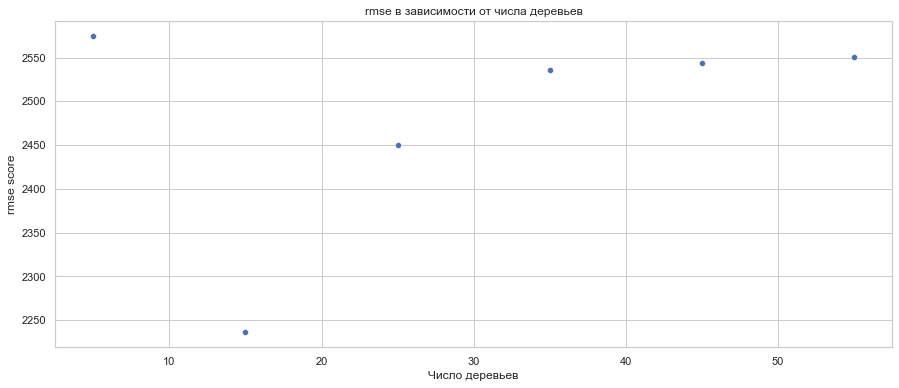

In [114]:
%%time
# посмотрю так же для решающего дерева
model_building('tree', features_train_ohe, target_train, range(5, 60, 10), range(1, 2), 3)

здесь видно переобучение с увеличением глубины дерева, посмотрю зону 10-20

Для модели tree лучшее значение rmse при кросс-валидации: 2213.1365093349223 при этом глубина дерева: 12
CPU times: total: 1min 46s
Wall time: 1min 46s


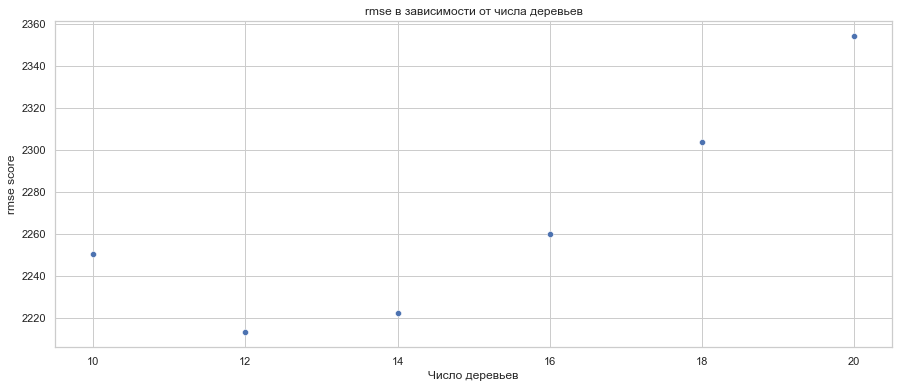

In [115]:
%%time
model_building('tree', features_train_ohe, target_train, range(10, 21, 2), range(1, 2), 3)

12 оптимальнее всего (в случае случайного леса с ростом числа деревьев улучшение было видно и с увеличением глубины, но оно достаточно быстро вышло на плато

In [116]:
%%time
# решил попробовать в GridSearch те же параметры, что в предыдущей функции ввести

# GridSearchCV для DecisionTreeRegressor

clf = DecisionTreeRegressor(random_state=12345)
parametrs = { 'max_depth': range (10, 21, 2) }

grid = GridSearchCV(clf, parametrs, cv=3, scoring=rmse_score)
grid.fit(features_train_ohe, target_train)

CPU times: total: 1min 53s
Wall time: 1min 53s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(random_state=12345),
             param_grid={'max_depth': range(10, 21, 2)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [117]:
# пытаюсь увидеть информацию о всех результататх GridSearch (но пока график не понял как вывести)
grid.cv_results_

{'mean_fit_time': array([4.6628317 , 5.22980523, 5.77663445, 6.13489866, 6.16684175,
        6.42773549]),
 'std_fit_time': array([0.26645721, 0.10041023, 0.09897495, 0.17251954, 0.09637451,
        0.05275259]),
 'mean_score_time': array([0.16444151, 0.20507948, 0.17238347, 0.16140763, 0.15620097,
        0.16141899]),
 'std_score_time': array([1.72656078e-02, 2.41770942e-02, 1.70356362e-02, 7.37495384e-03,
        8.90876224e-06, 7.36266107e-03]),
 'param_max_depth': masked_array(data=[10, 12, 14, 16, 18, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10},
  {'max_depth': 12},
  {'max_depth': 14},
  {'max_depth': 16},
  {'max_depth': 18},
  {'max_depth': 20}],
 'split0_test_score': array([-2262.37471152, -2226.5327569 , -2229.11878306, -2266.58737086,
        -2306.7436259 , -2368.65944956]),
 'split1_test_score': array([-2261.60623146, -2218.00854219, -2229.00335917, -2267.9805475 ,
  

In [118]:
grid.best_params_

{'max_depth': 12}

In [119]:
grid.best_score_

-2213.1365093349223

сейчас получилось применить GridSearchCV (но график пока не сумел вывести) - может это связано с ограниченностью интервала выбора, оптимальный параметр тоже 12,

In [120]:
%%time
# теперь посмотрю на результат для линейной регрессии
# Кросс-валидация для Линейной регрессии
model_linear = LinearRegression()                     # инициализация модели
scores = cross_val_score(model_linear, features_train_ohe, target_train, scoring=rmse_score, cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-2779.33426913 -2785.24892086 -2763.49960025 -2788.1393346
 -2714.37683155]
Средняя оценка качества модели: -2766.119791277605
CPU times: total: 1min 43s
Wall time: 21.8 s


с регрессией не очень хорошо получается
в итоге отпимальнее всего Random forest, с глубиной и числом деревьев по 18, в решающем дереве оптимальной была глубина 12


На DecisionTree лучший результат при глубине 12 (как и в прошлый раз) - 2212
У Линейной регрессии получается - 2763


#### Подбор параметров для LightGBM (версия с преобразованием с помощью OHE)

Здесь я достаточно долго думал, как лучше сделать, смотрел ряд различных ссылок:
- в первую очередь основную ссылку на LightGBM - там подробное описание, но не было примеров реализации кода (как обычно бывает в sklearn)
- также смотрел следующие ссылки:
- https://habr.com/ru/company/skillfactory/blog/530594/
- https://www.datatechnotes.com/2022/03/lightgbm-regression-example-in-python.html
- https://www.projectpro.io/recipes/use-lightgbm-classifier-and-regressor-in-python
- https://www.analyticsvidhya.com/blog/2021/08/complete-guide-on-how-to-use-lightgbm-in-python/
- https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/https://machinelearningmastery.com/light-gradient-boosted-machine-lightgbm-ensemble/  
у меня сложилось ощущение, что к использованию LightGBM можно подходить с разными интерфейсами (и многие примеры реализации показаны на более старых версиях)

Еще думал делать подобор через GridSearch (иногда удавалось получить результат, но пока что, как и в случае RandomForest - решил подбирать в цикле (т.к. с GridSearch у меня часто получаются сбои (зависает) причины, которых не могу понять) или даже просто поочередным вызовом вариантов (чтобы лучше видеть время выполнения и убеждаться, что процесс не завис)

В этом варианте (возможно его придеться сильно переделывать после ревью), решил вызывать и обучать модель примерно так же, как и в случае с более простыми (и проводить кросс-валидацию) и ориентироваться на несколько наиболее понятных мне гиперпараметров (и на которые обращено больше внимания в основной документации LightGBM)

Дальше напишу список из некоторых гиперпараметров, на которые решил обратить внимание (чтобы самому лучше представлять, что делаю).  
вообще описания по основной ссылке немного разняться и не могу сказать, что понял их хорошо

- boosting_type здесь хочу использовать Gradient Boosting Decision Tree 'gbdt',  
- num_leaves, как я понял основной параметр метода, отвечающий за управление сложностью модели, связан с глубиной num_leaves = 2^(max_depth), но num_leaves можно пробовать установить меньше соответствующих значений при глубине (если глубина 10, то число литьев будет выводиться как 1024, но можно поставить его меньше для лучшей точности) 
- max_depth=- 1 макимальная глубина меньше 0, означает отсутствие ограничений по глубине дерева (как я понимаю основным параметром становиться, число листьев)
- learning_rate (по умолчанию 0.1) Скорость обучения бустинга - меньшие скорости могут требовать большего количества деревьев.
- min_data_in_leaf в документации говорится, что этот параметр важен для предотвращения переобучения и что для большого набора данных достаточно установить значение в сотни или тысячи. как я понял сейчас этот параметр называетсяя **min_child_samples** (хотя не уверен)
- n_estimators (как я понимаю аналогичен num_iterations) по умолчанию=100, в документации указано, что: "как правило, если вы уменьшаете num_iterations, вам следует увеличить learning_rate" 

In [121]:
%%time
# посмотрю с параметрами по умолчанию
model_lgbm = LGBMRegressor(random_state=12345)               # инициализация модели
scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-1917.16998307 -1899.20228751]
Средняя оценка качества модели: -1908.186135292568
CPU times: total: 28.7 s
Wall time: 4.36 s


резльтат сопоставим с RandomForest после потбора гиперпараметров, но считался быстрее

дальше буду пытаться менять гиперпараметры по отдельности в циклах (из тех что перечислены выше), в тех случаях когда указана обратная свзяь (один меньше другой больше) - посмотрю на них вместе. 

Сейчас хочу понять правилен ли общий подход - поэтому пока не пытаюсь сделать процесс более оптимальным (через функции и как-то еще). Возможно более правильным было бы смотреть все комбинации параметров, но боюсь, что это может быть очень долгим поэтому сначал решил подобрать num_leaves, затем n_estimators, затем learning_rate и потом 

начну с **num_leaves** - подготовлю список с возрастающими значениями (остальные параметры пока по умолчанию)

*
Число листьев: 10 Средняя оценка качества модели: 2036.847169796562
*
Число листьев: 50 Средняя оценка качества модели: 1869.7978803014937
*
Число листьев: 100 Средняя оценка качества модели: 1836.1899577400277
*
Число листьев: 200 Средняя оценка качества модели: 1817.3696978786702
*
Число листьев: 300 Средняя оценка качества модели: 1809.9574023996056
*
Число листьев: 400 Средняя оценка качества модели: 1810.073176164939
*
Число листьев: 500 Средняя оценка качества модели: 1808.485262758309
*
Число листьев: 700 Средняя оценка качества модели: 1809.8866127660785
*
Число листьев: 1000 Средняя оценка качества модели: 1816.9103315055654
Лучшее значение rmse при кросс-валидации: 1808.485262758309 при этом число листьев дерева: 500
CPU times: total: 12min 44s
Wall time: 1min 24s


Text(0.5, 1.0, 'rmse в зависимости от числа листьев')

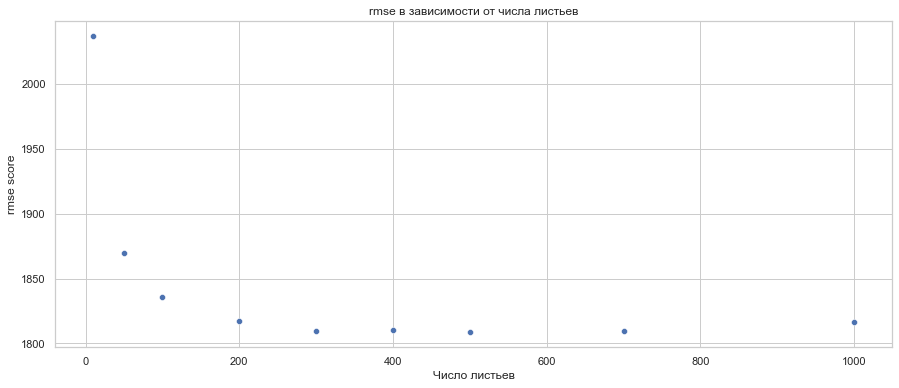

In [122]:
%%time
list_leaves = [10, 50, 100, 200, 300, 400, 500, 700, 1000]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_leaves_rmse = 0     # переменная для сохранения лучшего числа листьев при этом


for i in range(len(list_leaves)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=list_leaves[i],
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=0.1, 
        n_estimators=100,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('Число листьев:', list_leaves[i], 'Средняя оценка качества модели:', final_rmse_score)
    
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_leaves_rmse = list_leaves[i]
            
             
print('Лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом число листьев дерева:', best_leaves_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=list_leaves, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от глубины
plt.xlabel('Число листьев', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от числа листьев')

в зоне 300 - 500 оптимальные значения - попробую еще раз чуть подробнее посмотреть

*
Число листьев: 300 Средняя оценка качества модели: 1809.9574023996056
*
Число листьев: 325 Средняя оценка качества модели: 1808.6109263371786
*
Число листьев: 350 Средняя оценка качества модели: 1808.0304433850938
*
Число листьев: 375 Средняя оценка качества модели: 1807.5847056396456
*
Число листьев: 400 Средняя оценка качества модели: 1810.073176164939
*
Число листьев: 425 Средняя оценка качества модели: 1808.4505819247725
*
Число листьев: 450 Средняя оценка качества модели: 1807.8163816669821
*
Число листьев: 475 Средняя оценка качества модели: 1806.8618250561553
*
Число листьев: 500 Средняя оценка качества модели: 1808.485262758309
Лучшее значение rmse при кросс-валидации: 1806.8618250561553 при этом число листьев дерева: 475
CPU times: total: 14min 34s
Wall time: 1min 36s


Text(0.5, 1.0, 'rmse в зависимости от числа листьев')

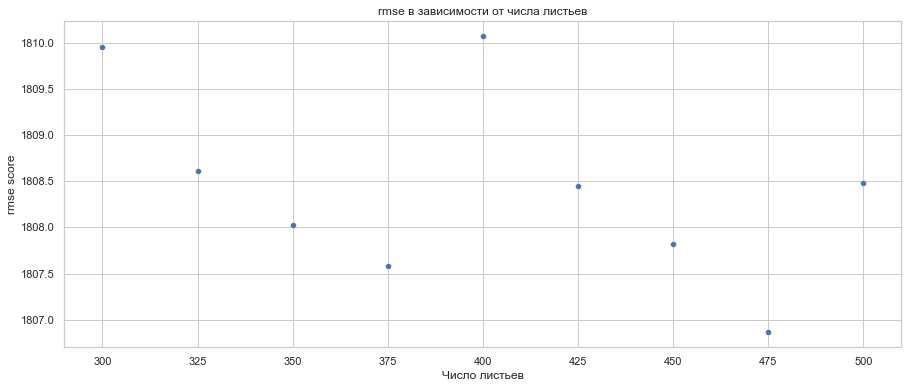

In [123]:
%%time
list_leaves = range(300, 502, 25)
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_leaves_rmse = 0     # переменная для сохранения лучшего числа листьев при этом


for i in range(len(list_leaves)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=list_leaves[i],
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=0.1, 
        n_estimators=100,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('Число листьев:', list_leaves[i], 'Средняя оценка качества модели:', final_rmse_score)
    
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_leaves_rmse = list_leaves[i]
            
             
print('Лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом число листьев дерева:', best_leaves_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=list_leaves, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от числа листьев
plt.xlabel('Число листьев', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от числа листьев')

думаю, что смотреть дальше не очень оправдано - буду считать оптимальным числом **350**  листьев

Далее по схожему принципу посмотрю на разные значения n_estimators с оптимальным числом листьев (остальное по умолчанию)

*
n_estimators: 10 Средняя оценка качества модели: 2512.7158266774495
*
n_estimators: 50 Средняя оценка качества модели: 1840.0971500811527
*
n_estimators: 100 Средняя оценка качества модели: 1808.0304433850938
*
n_estimators: 200 Средняя оценка качества модели: 1800.4800338955395
*
n_estimators: 300 Средняя оценка качества модели: 1800.89249598151
*
n_estimators: 400 Средняя оценка качества модели: 1803.2212627494705
*
n_estimators: 500 Средняя оценка качества модели: 1805.6876859943104
*
n_estimators: 700 Средняя оценка качества модели: 1811.669937578161
*
n_estimators: 1000 Средняя оценка качества модели: 1818.489206900518
лучшее значение rmse при кросс-валидации: 1800.4800338955395 при этом n_estimators: 200
CPU times: total: 35min 23s
Wall time: 3min 28s


Text(0.5, 1.0, 'rmse в зависимости от n_estimators')

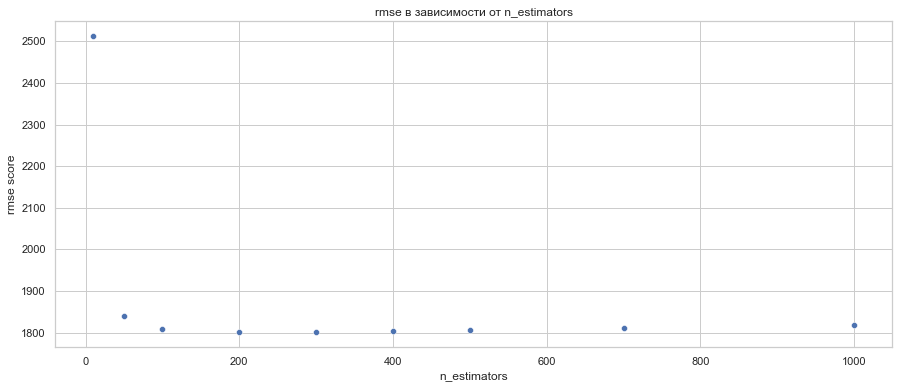

In [124]:
%%time
list_est = [10, 50, 100, 200, 300, 400, 500, 700, 1000]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_est_rmse = 0  # переменная для сохранения лучшего числа деревьев при этом


for i in range(len(list_est)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=350,
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=0.1, 
        n_estimators=list_est[i],
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('n_estimators:', list_est[i], 'Средняя оценка качества модели:', final_rmse_score)
    
     
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_est_rmse = list_est[i]
            
             
print('лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом n_estimators:', best_est_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=list_est, y=rmse_list)  # диаграмма рассеяния rmse в зависимости n_estimators
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от n_estimators')

Text(0.5, 1.0, 'rmse в зависимости от n_estimators')

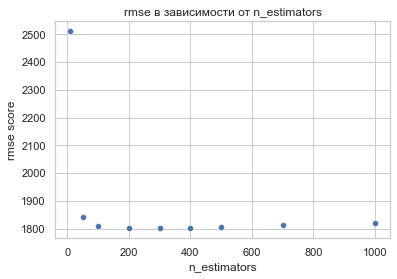

In [125]:
sns.scatterplot(x=list_est, y=rmse_list)  # диаграмма рассеяния rmse в зависимости n_estimators
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от n_estimators')

*
Learning rate: 1.0 Средняя оценка качества модели: 2444.600140525952
*
Learning rate: 0.5 Средняя оценка качества модели: 1997.0259092849383
*
Learning rate: 0.1 Средняя оценка качества модели: 1800.4800338955395
*
Learning rate: 0.05 Средняя оценка качества модели: 1802.718558909124
*
Learning rate: 0.01 Средняя оценка качества модели: 2048.3853599391996
*
Learning rate: 0.005 Средняя оценка качества модели: 2554.0551199101765
*
Learning rate: 0.001 Средняя оценка качества модели: 3897.636002022513
*
Learning rate: 0.0005 Средняя оценка качества модели: 4184.275151123133
*
Learning rate: 0.0001 Средняя оценка качества модели: 4440.4697525077645
лучшее значение rmse при кросс-валидации: 1800.4800338955395 при этом learning rate: 0.1
CPU times: total: 24min 18s
Wall time: 2min 26s


Text(0.5, 1.0, 'rmse в зависимости learning_rate')

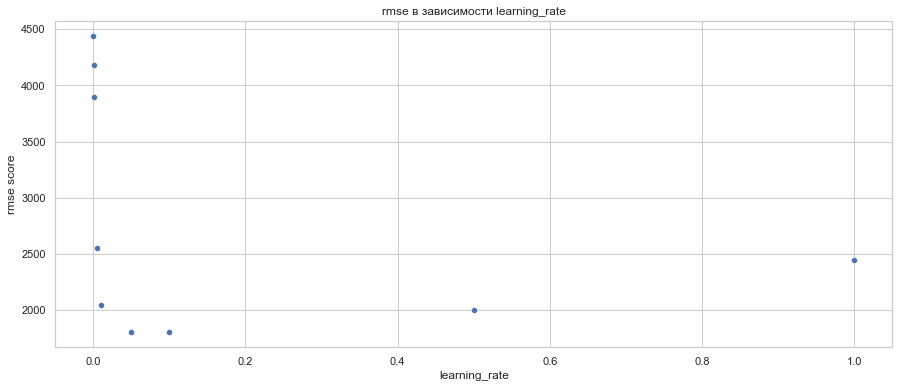

In [126]:
%%time
lrn_rate = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_lrn = 0  # переменная для сохранения лучшего learning_rate


for i in range(len(lrn_rate)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=350,
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=lrn_rate[i], 
        n_estimators=200,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('Learning rate:', lrn_rate[i], 'Средняя оценка качества модели:', final_rmse_score)
    
     
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_lrn = lrn_rate[i]
            
             
print('лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом learning rate:', best_lrn)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=lrn_rate, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от learning_rate
plt.xlabel('learning_rate', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости learning_rate')

сейчас лучшее значение при learning_rate = 0.1 (как значение по умолчанию, хотя при 0.05 не сильно отличается).

*
min_child_rate: 10 Средняя оценка качества модели: 1794.2811433147158
*
min_child_rate: 20 Средняя оценка качества модели: 1800.4800338955395
*
min_child_rate: 50 Средняя оценка качества модели: 1805.6488105553065
*
min_child_rate: 100 Средняя оценка качества модели: 1820.882797073663
*
min_child_rate: 200 Средняя оценка качества модели: 1835.3314563136792
*
min_child_rate: 400 Средняя оценка качества модели: 1868.02523478647
*
min_child_rate: 1000 Средняя оценка качества модели: 1923.8256141764073
лучшее значение rmse при кросс-валидации: 1794.2811433147158 при этом min_child_rate: 10
CPU times: total: 17min 2s
Wall time: 1min 44s


Text(0.5, 1.0, 'rmse в зависимости от min_child_rate')

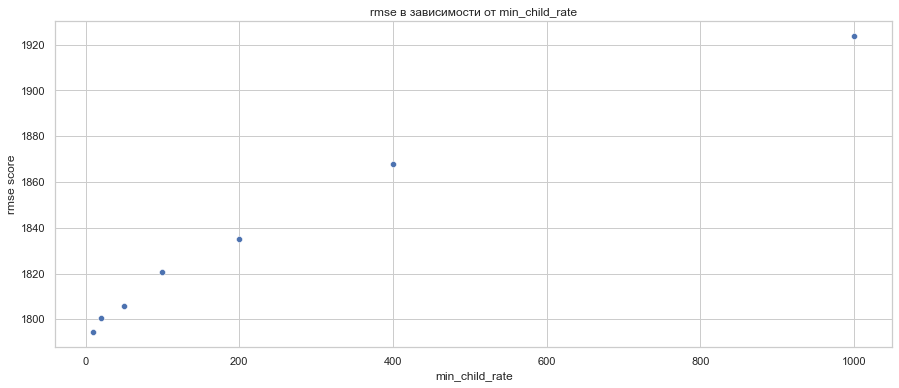

In [127]:
%%time
min_child_rate = [10, 20, 50, 100, 200, 400, 1000]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_mct_rmse = 0  # переменная для сохранения лучшего min_child_rate при этом


for i in range(len(min_child_rate)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=350,
        min_child_samples=min_child_rate[i],
        max_depth=- 1, 
        learning_rate=0.1, 
        n_estimators=200,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('min_child_rate:', min_child_rate[i], 'Средняя оценка качества модели:', final_rmse_score)
    
     
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующего гиперпараметра
        best_rmse = final_rmse_score
        best_mct_rmse = min_child_rate[i]
            
             
print('лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом min_child_rate:', best_mct_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=min_child_rate, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от min_child_rate
plt.xlabel('min_child_rate', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от min_child_rate')

лучшим значением min_child_samples оказывается, 10
Далее посмотрю на результат кросс-валидации для подобранных гиперпараметров

In [128]:
%%time
# Кросс-валидация для LGBM регрессии

model_lgbm = LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=350,
    min_child_samples=10,
    max_depth=- 1, 
    learning_rate=0.1, 
    n_estimators=200,
    random_state=12345)               # инициализация модели

scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-1753.71039177 -1769.56073427 -1775.55087715 -1766.49187589
 -1716.87510752]
Средняя оценка качества модели: -1756.4377973191342
CPU times: total: 6min 24s
Wall time: 39.8 s


и отдельно посмотрю на результаты кросс-валидации для случайного леса и решающего дерева (для линейной регресии уже есть выше)

In [129]:
#%%time
# Кросс-валидация для Random_forest OHE
#model_rf = RandomForestRegressor(random_state=12345, n_estimators= 18, max_depth=18)
#scores = cross_val_score(model_rf, features_train_ohe, target_train, scoring=rmse_score, cv=5)   # кросс-валидация
#final_score = scores.mean()                                                  # cредняя оценка качества модели
#print(scores)
#print('Средняя оценка качества модели:', final_score)

In [130]:
%%time
# Кросс-валидация для Decision_Tree OHE
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=12)
scores = cross_val_score(model_dt, features_train_ohe, target_train, scoring=rmse_score, cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-2203.36112363 -2210.05264029 -2213.30669257 -2195.65470387
 -2153.55897367]
Средняя оценка качества модели: -2195.186826806028
CPU times: total: 30.5 s
Wall time: 30.5 s


In [131]:
%%time
# Кросс-валидация для Decision_Tree Ordinal - здесь попробую с теми же гиперпараметрами
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=12)
scores = cross_val_score(model_dt, features_train_ord, target_train, scoring=rmse_score, cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-2183.31846699 -2206.45940381 -2191.56072101 -2189.85024878
 -2131.65635563]
Средняя оценка качества модели: -2180.5690392424467
CPU times: total: 4.56 s
Wall time: 4.56 s


Дальше хочу сделать сравнительную таблицу с оптимальным результатом по каждой модели (на следующем этапе тоже буду делать такую), как я понял из проекта отрицательные значения метрики возникают из-за "разворота при кросс-валидаци" - фактически везде воспринимаю как положительные (будет перед выводами)

В общем LightGBM демонстрирует результат лучше других, при этом почти в три раза быстрее, чем RandomForest

#### Подбор параметров для LightGBM (версия с преобразованием с помощью OrdinalEncoder)

In [132]:
%%time
# посмотрю с параметрами по умолчанию
model_lgbm = LGBMRegressor(random_state=12345)               # инициализация модели
scores = cross_val_score(model_lgbm, features_train_ord, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-1935.61396592 -1914.67115042]
Средняя оценка качества модели: -1925.1425581714086
CPU times: total: 14.3 s
Wall time: 1.27 s


*
Число листьев: 10 Средняя оценка качества модели: 2036.8474927326074
*
Число листьев: 50 Средняя оценка качества модели: 1887.6876278535933
*
Число листьев: 100 Средняя оценка качества модели: 1848.4841006058616
*
Число листьев: 200 Средняя оценка качества модели: 1826.9040572133858
*
Число листьев: 300 Средняя оценка качества модели: 1818.9926855501083
*
Число листьев: 400 Средняя оценка качества модели: 1814.5418157813717
*
Число листьев: 500 Средняя оценка качества модели: 1815.269428329235
*
Число листьев: 700 Средняя оценка качества модели: 1818.6914956713458
*
Число листьев: 1000 Средняя оценка качества модели: 1823.8727869448098
Лучшее значение rmse при кросс-валидации: 1814.5418157813717 при этом число листьев дерева: 400
CPU times: total: 9min 3s
Wall time: 48 s


Text(0.5, 1.0, 'rmse в зависимости от числа листьев')

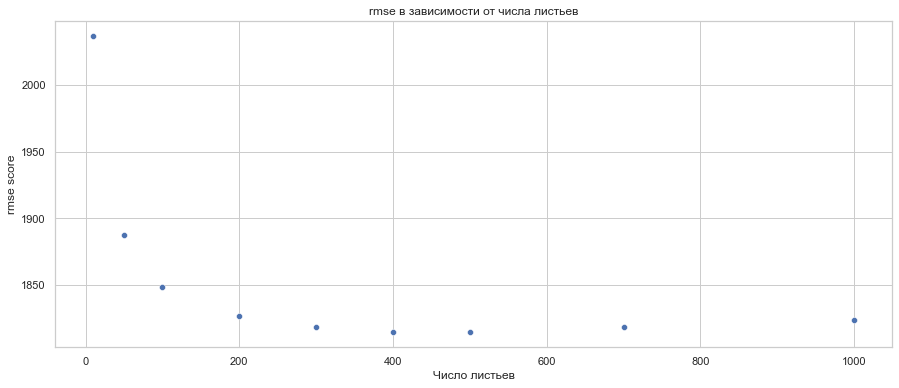

In [133]:
%%time
list_leaves = [10, 50, 100, 200, 300, 400, 500, 700, 1000]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_leaves_rmse = 0     # переменная для сохранения лучшего числа листьев при этом


for i in range(len(list_leaves)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=list_leaves[i],
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=0.1, 
        n_estimators=100,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ord, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('Число листьев:', list_leaves[i], 'Средняя оценка качества модели:', final_rmse_score)
    
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_leaves_rmse = list_leaves[i]
            
             
print('Лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом число листьев дерева:', best_leaves_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=list_leaves, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от глубины
plt.xlabel('Число листьев', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от числа листьев')

*
Число листьев: 350 Средняя оценка качества модели: 1817.211899231279
*
Число листьев: 375 Средняя оценка качества модели: 1815.7244622178926
*
Число листьев: 400 Средняя оценка качества модели: 1814.5418157813717
*
Число листьев: 425 Средняя оценка качества модели: 1815.5019960551563
*
Число листьев: 450 Средняя оценка качества модели: 1814.4112978166115
*
Число листьев: 475 Средняя оценка качества модели: 1816.1308164192974
*
Число листьев: 500 Средняя оценка качества модели: 1815.269428329235
*
Число листьев: 525 Средняя оценка качества модели: 1816.5662998534785
*
Число листьев: 550 Средняя оценка качества модели: 1813.7288344550361
Лучшее значение rmse при кросс-валидации: 1813.7288344550361 при этом число листьев дерева: 550
CPU times: total: 11min 11s
Wall time: 60 s


Text(0.5, 1.0, 'rmse в зависимости от числа листьев')

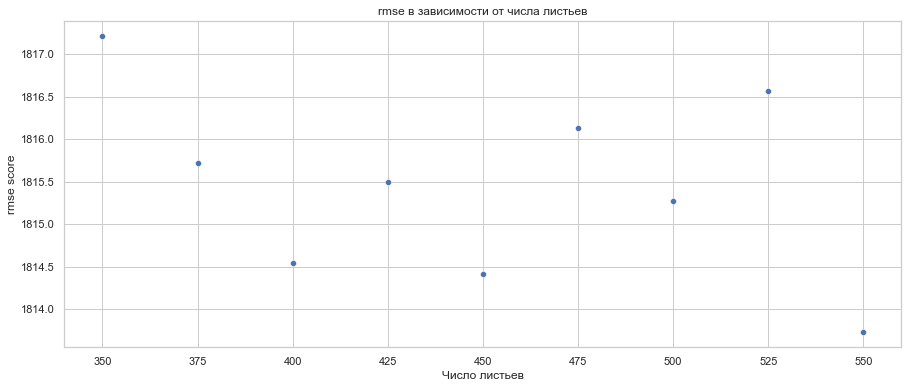

In [134]:
%%time
list_leaves = range(350, 552, 25)
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_leaves_rmse = 0     # переменная для сохранения лучшего числа листьев при этом


for i in range(len(list_leaves)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=list_leaves[i],
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=0.1, 
        n_estimators=100,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ord, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('Число листьев:', list_leaves[i], 'Средняя оценка качества модели:', final_rmse_score)
    
    rmse_list.append(final_rmse_score)          # добавление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_leaves_rmse = list_leaves[i]
            
             
print('Лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом число листьев дерева:', best_leaves_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=list_leaves, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от числа листьев
plt.xlabel('Число листьев', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от числа листьев')

значение скачет лучше всего было при 525 листьев

*
n_estimators: 10 Средняя оценка качества модели: 2493.5511384827714
*
n_estimators: 50 Средняя оценка качества модели: 1841.8745544601734
*
n_estimators: 100 Средняя оценка качества модели: 1816.5662998534785
*
n_estimators: 200 Средняя оценка качества модели: 1811.2443947069175
*
n_estimators: 300 Средняя оценка качества модели: 1813.0829361978538
*
n_estimators: 400 Средняя оценка качества модели: 1816.7192376986513
*
n_estimators: 500 Средняя оценка качества модели: 1819.6049385127867
*
n_estimators: 700 Средняя оценка качества модели: 1824.394896821706
*
n_estimators: 1000 Средняя оценка качества модели: 1829.9945552507852
лучшее значение rmse при кросс-валидации: 1811.2443947069175 при этом n_estimators: 200
CPU times: total: 37min 4s
Wall time: 3min 21s


Text(0.5, 1.0, 'rmse в зависимости от n_estimators')

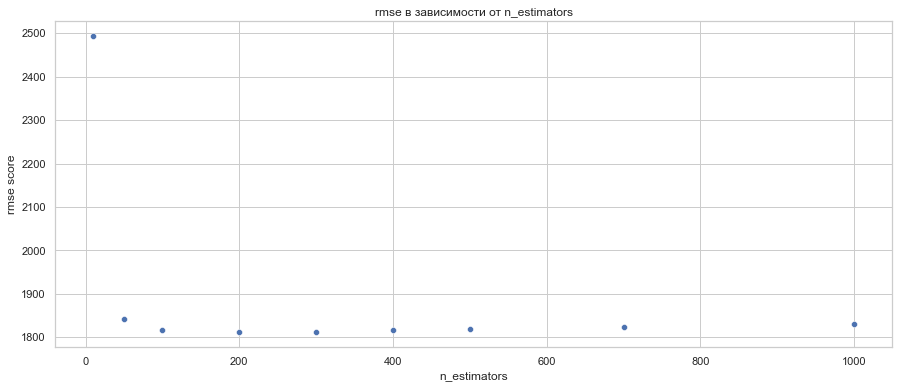

In [135]:
%%time
list_est = [10, 50, 100, 200, 300, 400, 500, 700, 1000]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_est_rmse = 0  # переменная для сохранения лучшего числа деревьев при этом


for i in range(len(list_est)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=525,
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=0.1, 
        n_estimators=list_est[i],
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ord, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('n_estimators:', list_est[i], 'Средняя оценка качества модели:', final_rmse_score)
    
     
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_est_rmse = list_est[i]
            
             
print('лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом n_estimators:', best_est_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=list_est, y=rmse_list)  # диаграмма рассеяния rmse в зависимости n_estimators
plt.xlabel('n_estimators', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от n_estimators')

*
Learning rate: 1.0 Средняя оценка качества модели: 2526.8652448300127
*
Learning rate: 0.5 Средняя оценка качества модели: 2030.9515502025988
*
Learning rate: 0.1 Средняя оценка качества модели: 1811.2443947069175
*
Learning rate: 0.05 Средняя оценка качества модели: 1807.5545781227684
*
Learning rate: 0.01 Средняя оценка качества модели: 2034.6336301986319
*
Learning rate: 0.005 Средняя оценка качества модели: 2534.1252444689944
*
Learning rate: 0.001 Средняя оценка качества модели: 3890.5327322668504
*
Learning rate: 0.0005 Средняя оценка качества модели: 4180.3564196206335
*
Learning rate: 0.0001 Средняя оценка качества модели: 4439.6222716175125
лучшее значение rmse при кросс-валидации: 1807.5545781227684 при этом learning rate: 0.05
CPU times: total: 25min 12s
Wall time: 2min 14s


Text(0.5, 1.0, 'rmse в зависимости learning_rate')

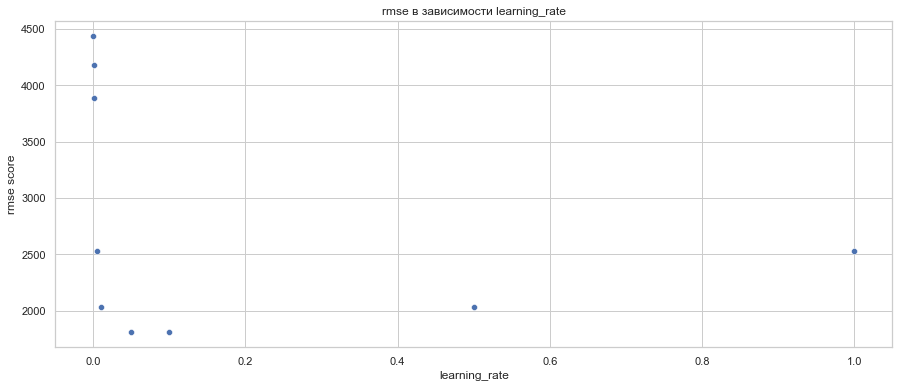

In [136]:
%%time
lrn_rate = [1.0, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_lrn = 0  # переменная для сохранения лучшего learning_rate


for i in range(len(lrn_rate)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=525,
        min_child_samples=20,
        max_depth=- 1, 
        learning_rate=lrn_rate[i], 
        n_estimators=200,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ord, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('Learning rate:', lrn_rate[i], 'Средняя оценка качества модели:', final_rmse_score)
    
     
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующей глубины дерева и числа деревьев
        best_rmse = final_rmse_score
        best_lrn = lrn_rate[i]
            
             
print('лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом learning rate:', best_lrn)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=lrn_rate, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от learning_rate
plt.xlabel('learning_rate', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости learning_rate')

здесь лучший learning_rate 0.05 (почти неотличим от 0.1)

*
min_child_rate: 10 Средняя оценка качества модели: 1805.2424880793405
*
min_child_rate: 20 Средняя оценка качества модели: 1807.5545781227684
*
min_child_rate: 50 Средняя оценка качества модели: 1810.158354528719
*
min_child_rate: 100 Средняя оценка качества модели: 1822.2608603791077
*
min_child_rate: 200 Средняя оценка качества модели: 1842.729384029412
*
min_child_rate: 400 Средняя оценка качества модели: 1880.1822067956036
*
min_child_rate: 1000 Средняя оценка качества модели: 1950.7716469515512
лучшее значение rmse при кросс-валидации: 1805.2424880793405 при этом min_child_rate: 10
CPU times: total: 16min 59s
Wall time: 1min 29s


Text(0.5, 1.0, 'rmse в зависимости от min_child_rate')

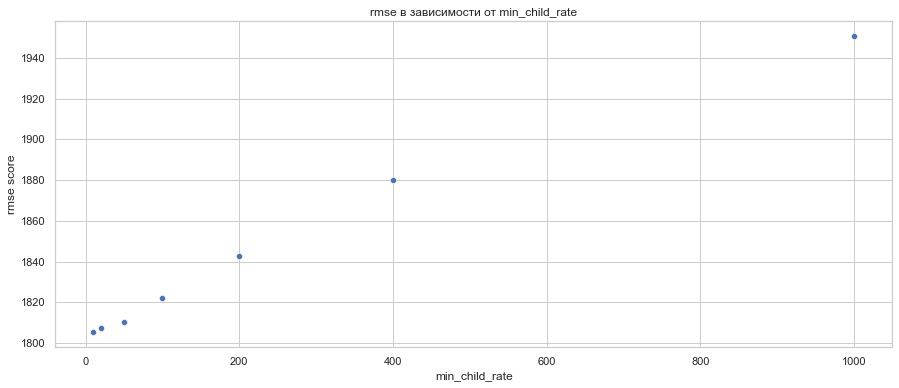

In [137]:
%%time
min_child_rate = [10, 20, 50, 100, 200, 400, 1000]
rmse_list = []
best_rmse = 10000        # переменная для сохранения лучшего значения rmse т.к. чем меньше тем лучше задал 10000 как базовое
best_mct_rmse = 0  # переменная для сохранения лучшего min_child_rate при этом


for i in range(len(min_child_rate)):
        
    model_lgbm = LGBMRegressor(
        boosting_type='gbdt', 
        num_leaves=525,
        min_child_samples=min_child_rate[i],
        max_depth=- 1, 
        learning_rate=0.05, 
        n_estimators=200,
        random_state=12345)               # инициализация модели
    
    print('*') 
    scores = cross_val_score(model_lgbm, features_train_ord, target_train, scoring=rmse_score, cv=2)   # кросс-валидация
    final_rmse_score = np.abs(scores.mean())                                                  # cредняя оценка качества модели
    print('min_child_rate:', min_child_rate[i], 'Средняя оценка качества модели:', final_rmse_score)
    
     
    rmse_list.append(final_rmse_score)          # добаление значения rmse в список для графика
         
    if final_rmse_score < best_rmse:   # выцепление лучшего значения rmse и соответствующего гиперпараметра
        best_rmse = final_rmse_score
        best_mct_rmse = min_child_rate[i]
            
             
print('лучшее значение rmse при кросс-валидации:', best_rmse, 'при этом min_child_rate:', best_mct_rmse)
  
            
plt.figure(figsize=(15, 6))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=1)
                        
sns.scatterplot(x=min_child_rate, y=rmse_list)  # диаграмма рассеяния rmse в зависимости от min_child_rate
plt.xlabel('min_child_rate', fontsize=12)
plt.ylabel('rmse score', fontsize=12)
plt.title('rmse в зависимости от min_child_rate')

тут как и в прошлый раз 10

In [138]:
%%time
# Кросс-валидация для LGBM регрессии (Ordinal)

model_lgbm = LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=525,
    min_child_samples=10,
    max_depth=- 1, 
    learning_rate=0.05, 
    n_estimators=200,
    random_state=12345)               # инициализация модели

scores = cross_val_score(model_lgbm, features_train_ohe, target_train, scoring=rmse_score, cv=5)   # кросс-валидация
final_score = scores.mean()                                                  # cредняя оценка качества модели
print(scores)
print('Средняя оценка качества модели:', final_score)

[-1752.7446487  -1770.36730768 -1779.00559032 -1767.07035283
 -1717.5427551 ]
Средняя оценка качества модели: -1757.3461309270365
CPU times: total: 9min 17s
Wall time: 56.5 s


In [139]:
table = pd.DataFrame(data=[[1758.63, '1:20 min'], [1759.41, '0:51.7 min'], [3080.34, '0:01.98 min'], [2196.54, '1:02 min'], [2182.46, '0:12.8 min']], columns=['rmse', 'speed'])
table.index = ['LightGBMRegressor_OHE', 'LightGBMRegressor_Ordinal', 'LinearRegression_OHE', 'DecisionTreeRegressor_OHE', 'DecisionTreeRegressor_Ordinal']
table

,rmse,speed
LightGBMRegressor_OHE,"1,758.63",1:20 min
LightGBMRegressor_Ordinal,"1,759.41",0:51.7 min
LinearRegression_OHE,"3,080.34",0:01.98 min
DecisionTreeRegressor_OHE,"2,196.54",1:02 min
DecisionTreeRegressor_Ordinal,"2,182.46",0:12.8 min


### Вывод по шагу



- проведена кросс-валидация для трех моделей (ohe заметно медленне ordinal), random_forest пока не трогал (т.к. очень медленно). Качество сходных моделей при применении OHE и Ordinal примерно сходное. У Линейной регрессии (только OHE) опять самое низкое
- подрбоаны гиперпараметры

## Анализ моделей

здесь посмотрю на модели с оптимальными гиперпараметрами на тестовой выборке

### RandomForest

In [140]:
#%%time
#model_rf = RandomForestRegressor(random_state=12345, n_estimators= 18, max_depth=18)
#model_rf.fit(features_train, target_train)
#predictions_rf = model_rf.predict(features_test)
#rmse_score_rf = rmse(target_test, predictions_rf)               # подсчет rmse
#print(f'rmse по RandomForestRegressor: {rmse_score_rf:.4f}')

### DecisionTree

In [141]:
%%time
# для OHE
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=12)
model_dt.fit(features_train_ohe, target_train)
predictions_dt = model_dt.predict(features_test_ohe)
rmse_score_dt = rmse(target_test, predictions_dt)               # подсчет rmse
print(f'rmse по DecisionTreeRegressor: {rmse_score_dt:.4f}')

rmse по DecisionTreeRegressor: 2166.4523
CPU times: total: 7.3 s
Wall time: 7.3 s


In [142]:
%%time
# для ordinal
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=12)
model_dt.fit(features_train_ord, target_train)
predictions_dt = model_dt.predict(features_test_ord)
rmse_score_dt = rmse(target_test, predictions_dt)               # подсчет rmse
print(f'rmse по DecisionTreeRegressor: {rmse_score_dt:.4f}')

rmse по DecisionTreeRegressor: 2150.3610
CPU times: total: 1.19 s
Wall time: 1.2 s


### Linear Regression

In [143]:
%%time
model_linear = LinearRegression()   
model_linear.fit(features_train_ohe, target_train)
predictions_linear = model_linear.predict(features_test_ohe)
rmse_score_linear = rmse(target_test, predictions_linear)               # подсчет rmse
print(f'rmse по LinearRegression: {rmse_score_linear:.4f}')

rmse по LinearRegression: 2772.7517
CPU times: total: 24.8 s
Wall time: 5.07 s


### LightGBM Regressor

#### Вариант для OHE

In [144]:
%%time
# посмотрю с праметрами по умолчанию
model_lgbm = LGBMRegressor(random_state=12345)               # инициализация модели

model_lgbm.fit(features_train_ohe, target_train)
predictions_lbm = model_lgbm.predict(features_test_ohe)
rmse_score_lbm = rmse(target_test, predictions_lbm)               # подсчет rmse
print(f'rmse по LGBMRegressor c гиперпараметрами по умолчанию: {rmse_score_lbm:.4f}')

rmse по LGBMRegressor c гиперпараметрами по умолчанию: 1892.2581
CPU times: total: 22 s
Wall time: 3.02 s


In [145]:
%%time
# и с подобранными гиперпараметрами
model_lgbm_p = LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=350,
    min_child_samples=10,
    max_depth=- 1, 
    learning_rate=0.1, 
    n_estimators=200,
    random_state=12345)               # инициализация модели


model_lgbm_p.fit(features_train_ohe, target_train)
predictions_lbm_p = model_lgbm_p.predict(features_test_ohe)
rmse_score_lbm_p = rmse(target_test, predictions_lbm_p)               # подсчет rmse
print(f'rmse по LGBMRegressor c подобранными гиперпараметрами: {rmse_score_lbm_p:.4f}')

rmse по LGBMRegressor c подобранными гиперпараметрами: 1735.5522
CPU times: total: 1min 21s
Wall time: 8.56 s


пока смотрел, как работать с LightGBM (а также в ходе сборного проекта) видел способ отображения важности признаков (в ходе сборного проекта смотрел скоррелированность признаков и удалял такие) **но в случае с OHE скорее всего это будет кашей - попробую с ordinal**

#### Вариант для Ordinal

In [146]:
%%time
# посмотрю с праметрами по умолчанию
model_lgbm = LGBMRegressor(random_state=12345)               # инициализация модели

model_lgbm.fit(features_train_ord, target_train)
predictions_lbm = model_lgbm.predict(features_test_ord)
rmse_score_lbm = rmse(target_test, predictions_lbm)               # подсчет rmse
print(f'rmse по LGBMRegressor c гиперпараметрами по умолчанию: {rmse_score_lbm:.4f}')

rmse по LGBMRegressor c гиперпараметрами по умолчанию: 1911.9702
CPU times: total: 14.9 s
Wall time: 1.47 s


In [147]:
%%time
# и с подобранными гиперпараметрами
model_lgbm_p = LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=525,
    min_child_samples=10,
    max_depth=- 1, 
    learning_rate=0.05, 
    n_estimators=200,
    random_state=12345)               # инициализация модели


model_lgbm_p.fit(features_train_ord, target_train)
predictions_lbm_p = model_lgbm_p.predict(features_test_ord)
rmse_score_lbm_p = rmse(target_test, predictions_lbm_p)               # подсчет rmse
print(f'rmse по LGBMRegressor c подобранными гиперпараметрами: {rmse_score_lbm_p:.4f}')

rmse по LGBMRegressor c подобранными гиперпараметрами: 1751.9024
CPU times: total: 1min 32s
Wall time: 7.94 s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

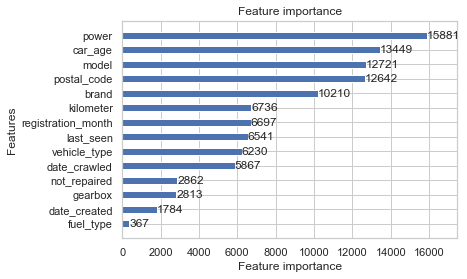

In [148]:
lgb.plot_importance(model_lgbm_p, height=.5)

в данном случае наболее важны были мощность (что логично - чем мощнее - тем дороже), год - чем новее - тем дороже, модель и марка тоже одни из самых важных. Думаю, что такая низкая важность топлива связана с подавляющим преобладанием бензиновых машин в датасете.

### Dummy Regressor
Думаю, что для полной картины надо провести сравнение с DummyRegressor (насколько я понимаю результат для OHE и Ordinal должен быть одинаковым)

In [149]:
%%time
# смотрю результат с помощью DummyRegressor 
dummy_reg = DummyRegressor(strategy="mean")   # strategy выбрал mean (думаю, что в данном случае это лучше, чем median, хотя точно не уверен)
dummy_reg.fit(features_train_ord, target_train)
predictions_dummy = dummy_reg.predict(features_test_ord)
rmse_score_dummy = rmse(target_test, predictions_dummy)               # подсчет rmse
print(f'rmse по DummyRegressor: {rmse_score_dummy:.4f}')

rmse по DummyRegressor: 4514.4890
CPU times: total: 0 ns
Wall time: 2 ms


### Сравнение результатов
еще раз выведу таблицу со сравнением результатов rmse и времени (теперь уже по тествовой выборке)

In [150]:
table = pd.DataFrame(data=[[1893, 2.95], [1733, 7.72], [1909, 0.843], [1743, 6.98], [2781, 5.11], [2158, 11.6], [2168, 1.21], [4521, 0.002]], columns=['rmse', 'speed_seconds'])
table.index = ['LightGBMRegressor enabled_OHE', 'LightGBMRegressor params_OHE', 'LightGBMRegressor enabled_Ordinal', 'LightGBMRegressor params_Ordinal','LinearRegression_OHE', 'DecisionTreeRegressor_OHE', 'DecisionTreeRegressor_Ordinal', 'DummyRegressor']
table

,rmse,speed_seconds
LightGBMRegressor enabled_OHE,1893,2.95
LightGBMRegressor params_OHE,1733,7.72
LightGBMRegressor enabled_Ordinal,1909,0.84
LightGBMRegressor params_Ordinal,1743,6.98
LinearRegression_OHE,2781,5.11
DecisionTreeRegressor_OHE,2158,11.60
DecisionTreeRegressor_Ordinal,2168,1.21
DummyRegressor,4521,0.00


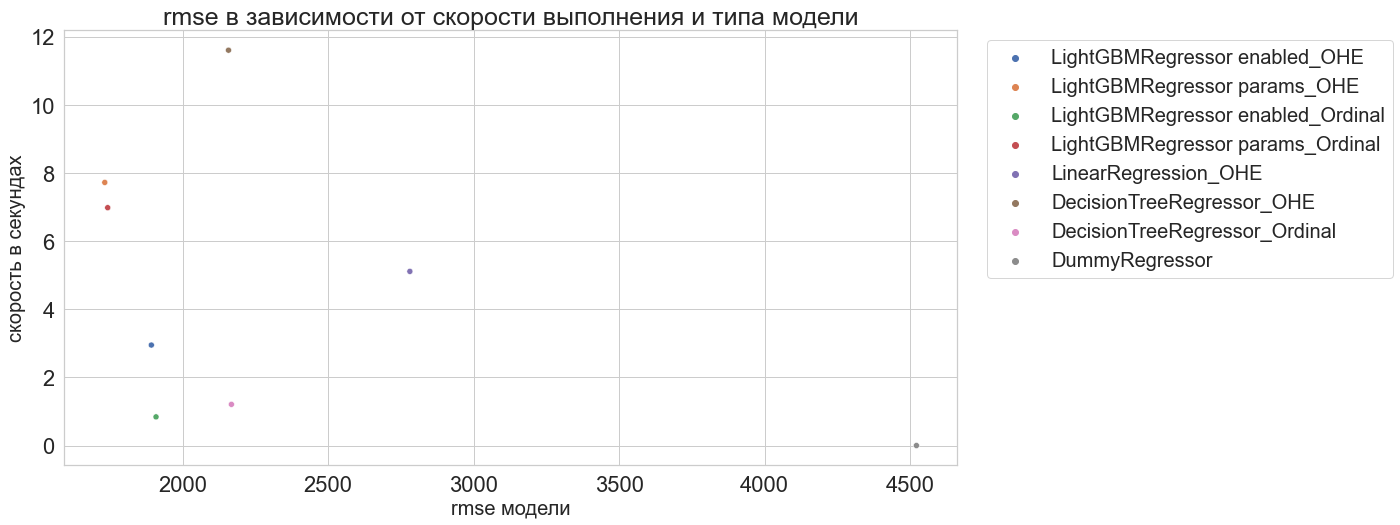

In [151]:
# сделаю график в координатах времени выполнения и rmse (тип модели выделю цветом)

plt.figure(figsize=(16, 8))
sns.set(context = 'notebook', style = 'whitegrid', font_scale=2)

sns.scatterplot(x=table['rmse'], y=table['speed_seconds'], hue=table.index)  # диаграмма рассеяния качетсва модели в зависимости от глубины деревьев
plt.xlabel('rmse модели', fontsize=20)
plt.ylabel('скорость в секундах', fontsize=20)            
plt.legend(title='число деревьев', bbox_to_anchor = (1,1)) # сдвиг легенды
plt.title('rmse в зависимости от скорости выполнения и типа модели', fontsize=25)
plt.legend(bbox_to_anchor = (1.5,1), fontsize=20)

### Общий вывод


- удалены дубликаты (в основном появивщиеся после округления дат до дня)
- все признаки можно воспринимать как категориальные
- обработаны выбросы и пропуски
- проведена кросс-валидация для четырех моделей
- проведено анализ моделей на тестовой выборке:
        -- все модели работают лучше чем DummyRegressor
        -- быстрее всего Линейная регрессия (но плохо соответствует целевой метрике), медленне всех RandomForest (второе место по качеству, но несильно отличается от третьего)
        -- лучше всего показывает себя LightGBM - самый качественный результат с настройкой гиперпараметров при этом достаточно быстро работает (почти как DummyRegressor), без настройки выдает результат чуть хуже, чем RandomForest, но значительно быстрее (примерно как DecisionTree)
        -- оптимальнее всего считаю LightGBM с настройкой гиперпараметров
        -- наиболее важные признаки: мощность, год, модель, индекс и марка машины


- Модели сделанные после преобразования OHE считаются медленнее, чем после Ordinal
- LightGBM c настройкой гиперпараметров даёт самый лучший результат (в общем близкий к тем что был в предыдущей версии)
- Линейная регрессия дает результат хуже, чем другие модели (но все дают результат лучше, чем DummyRegressor)
    
